In [1]:
# Sample to be processed
study = 'scmznos_valtor_combined'


In [2]:
# Input/output/resource directories
place = 'nemo'
scratchdir = "/plus/scratch/users/scott/projects/scmznos_valtor"
rawdir = f'{scratchdir}/raw_data'
outdir = f'{scratchdir}/project_results'
datadir = f'{scratchdir}/resources'
commonsdir = '/plus/data/@data_scott/common_resources'
syncdir = '/home/scott/Sync/scmznos_sync'

In [3]:
# Load libraries
import os
import sklearn
import pickle
import pandas as pd
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from scipy import io

import scanpy as sc
import anndata as ad
import pybiomart as pbm
import leidenalg as la
import scrublet as scr

import graphtools as gt
from pygsp import graphs, filters
import phate
import magic
import scprep
import sklearn
import meld

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
import natsort

# Package settings
sc.settings.autosave = False
sc.settings.figdir = f'{syncdir}/'
np.random.seed(42)
font = {'size'   : 14}
mpl.rc('font', **font)
mpl.rcParams['animation.embed_limit'] = 1000
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
# Show loaded libraries
import session_info
session_info.show()

In [5]:
from statsmodels.stats.multitest import multipletests
from fisher import pvalue_npy
import numpy as np
import pandas as pd

def OR(adata, cluster_col = 'Subtissue', cluster = 'Integument', eps = 1e-7, correction = 'fdr_bh', return_significant = True, p_threshold = 0.05, OR_cutoff=None, FE_cutoff=None):

    # Binarise expression data
    detection_data = adata.X.copy()
    detection_data.data[detection_data.data != 0] = 1

    # Binarise cluster membership and make 1d matrix
    membership = np.array(adata.obs[cluster_col] == cluster)
    membership_data = np.reshape(membership, (detection_data.shape[0], 1)).astype(int)

    # Calculate contigency table
    tp = np.sum(np.add(membership_data, detection_data.toarray()) == 2, axis=0).astype(np.uint)
    fp = np.sum(np.subtract(detection_data.toarray(), membership_data) == 1, axis=0).astype(np.uint)
    fn = np.sum(np.subtract(membership_data, detection_data.toarray()) == 1, axis=0).astype(np.uint)
    tn = np.sum(np.add(membership_data, detection_data.toarray()) == 0, axis=0).astype(np.uint)

    # Calculate odds ratio
    OR = ((tp + eps) / (fp + eps)) / ((fn + eps) / (tn + eps))
    # OR = np.nan_to_num(OR)

    # Fold enrichment
    FE = ((tp + eps) / (tp + fn + eps)) / ((tp + fp + eps) / (tp + fp + fn + tn + eps))
    
    # Calculate fisher exact t-test
    _, _, twosided = pvalue_npy(tp, fp, fn, tn)

    # Multiple hypothesis test
    _, p_adjusted, _, _ = multipletests(twosided, alpha=0.05, method=correction, is_sorted=False, returnsorted=False)

    # Collate and return results in dataframe
    df = pd.DataFrame({"Cluster":cluster, "TP":tp, "FP":fp, "FN":fn, "TN":tn, "FE":FE, "OR":OR, "logOR":np.log2(OR), "P":twosided, "P_adjust":p_adjusted, 'log10P_adjust':-np.log10(p_adjusted)}, index=adata.var_names)

    # Filter to significant results
    if return_significant:
        df = df[df['P_adjust'] <= p_threshold]
    if OR_cutoff is not None:
        df = df[df['OR'] >= OR_cutoff]
    if FE_cutoff is not None:
        df = df[df['FE'] >= FE_cutoff]

    del detection_data
    del membership_data
    return df.sort_values(by=['logOR'], ascending=[False])


In [6]:
from joblib import Parallel, delayed
# from pyFunctions.utils import OR
import scanpy as sc

def enrichment(adata, clusters, n_jobs=3):

    # Creat results dict
    DG_dict={}
    
    # Odds ratio
    ORs = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(OR)(adata, cluster_col = clusters, cluster = st, eps = 1e-7, correction = 'fdr_bh', return_significant = False)
             for st in adata.obs[clusters].cat.categories.to_list())
    DDGs = {iclust['Cluster'].iloc[0] : iclust for iclust in ORs}
    del ORs
    
    # T-test
    sc.tl.rank_genes_groups(adata, groupby=clusters, use_raw=False, method='t-test_overestim_var', n_genes=None, pts=True)
    
    # Combine results
    for clust in list(DDGs.keys()):
        DDGs[clust]['OR_rank'] = list(range(1, DDGs[clust].shape[0]+1))
        DEGs = sc.get.rank_genes_groups_df(adata, group=clust)
        DEGs['lfc_rank'] = list(range(1, DEGs.shape[0]+1))
        DEGs.index = DEGs.names
        DGs = pd.concat([DDGs[clust], DEGs], axis=1)
        DGs['combined_rank'] = DGs['OR_rank'] + DGs['lfc_rank']
        DGs['both_sig'] = ((DGs['P_adjust'] < 0.05) & (DGs['pvals_adj'] < 0.05))
        DGs['either_sig'] = ((DGs['P_adjust'] < 0.05) | (DGs['pvals_adj'] < 0.05))

        DG_dict[clust] = DGs
        del DEGs

    del DDGs
    
    return DG_dict

### Load data

In [7]:
# Load preprocessed data
sdata_MZnps = sc.read_h5ad(f'{scratchdir}/preprocessed_data/Anndata_scmznos_valtor_combined_cells_preprocessed_annotated_FINAL.h5ad')
sdata_MZnps

AnnData object with n_obs × n_vars = 10551 × 19782
    obs: 'Sample', 'Mutant_A', 'Mutant_B', 'WT_A', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_noncoding', 'log1p_total_counts_noncoding', 'pct_counts_noncoding', 'total_counts_label', 'log1p_total_counts_label', 'pct_counts_label', 'Raw_GFPCAAX', 'Raw_DSRED38WT', 'Raw_HCD4ENRICHED', 'Detected_GFPCAAX', 'Detected_DSRED38WT', 'Detected_HCD4ENRICHED', 'Detected_number', 'Detected_any', 'Transplant', 'Transplant_WT', 'Transplant_KO', 'Condition_marker', 'WT_marker', 'KO_marker', 'Host_marker', 'log10_total_counts', 'Condition_SNP', 'Condition', 'Expression_GFPCAAX', 'Expression_DSRED38WT', 'E

In [8]:
# Store var info for import to merged object
var_info = sdata_MZnps.var

In [9]:
# Load preprocessed single-cell data from an h5ad file
sdata_zsf = sc.read_h5ad(
    f'{commonsdir}/scDatasets/zsf_reference/preprocessed_data/Anndata_zsf_reference_4-24hpf_cells_preprocessed.h5ad'
)
# Retain only variables (genes) with a valid 'EnsemblID' (not NaN)
sdata_zsf = sdata_zsf[:, ~sdata_zsf.var['EnsemblID'].isna()]

# Set variable names to their corresponding 'EnsemblID', ensuring all are strings
sdata_zsf.var_names = sdata_zsf.var['EnsemblID'].astype('str')

# Remove duplicated variable indices to ensure data integrity
sdata_zsf = sdata_zsf[:, ~sdata_zsf.var.index.duplicated()]

# Rename columns in the 'obs' (observations) dataframe for clarity
sdata_zsf.obs.rename(columns={"Tissue": "Shier_tissue", "Subtissue": "Shier_subtissue"}, inplace=True)

# Display the processed AnnData object for inspection
sdata_zsf


View of AnnData object with n_obs × n_vars = 114161 × 22628
    obs: 'n_genes_by_counts', 'total_counts', 'timepoint', 'Shier_tissue', 'cell_id', 'Shier_subtissue', '10hpf', 'Tissue_10hpf', 'Subtissue_10hpf', '12hpf', 'Tissue_12hpf', 'Subtissue_12hpf', '14hpf', 'Tissue_14hpf', 'Subtissue_14hpf', '16hpf', 'Tissue_16hpf', 'Subtissue_16hpf', '24hpf', 'Tissue_24hpf', 'Subtissue_24hpf', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_noncoding', 'log1p_total_counts_noncoding', 'pct_counts_noncoding', 'log10_total_counts', 'S_score', 'G2M_score', 'phase', 'Ectoderm_Shier_germlayer_score', 'Endoderm_Shier_germlayer_score', 'Mesoderm_Shier_germlayer_score', 'Other_Shier_germlayer_score', 'Fore-mid-brain_Shier_tissue_score', 'H

In [10]:
# Load Curtis annotations from a CSV file
curtis_annot = pd.read_csv(
    f"{commonsdir}/scDatasets/zsf_reference/resources/20231005_zsf_reference_leiden_res_2.0_annotation.csv"
)

# Merge Curtis annotations into the AnnData object's observation (obs) DataFrame
# Left join by matching 'Leiden_res_2' in the AnnData obs with the index of the Curtis annotations
annotation = sdata_zsf.obs.merge(
    curtis_annot[['Germlayer', 'Tissue']],  # Select only relevant columns for merging
    how='left',  # Perform a left join to keep all rows in the AnnData obs
    left_on='Leiden_res_2',  # Match rows using 'Leiden_res_2' from AnnData obs
    right_index=True  # Use the index of the Curtis annotations for matching
)

# Ensure the new annotation DataFrame retains the original AnnData obs index
annotation.index = sdata_zsf.obs.index

# Update the AnnData obs with the merged annotations
sdata_zsf.obs = annotation

# Optional: Save the updated obs to a CSV file for external use or validation
# sdata_zsf.obs.to_csv(f"{commonsdir}/scDatasets/zsf_reference/preprocessed_data/Obs_zsf_reference_4-24hpf_cells_all_genes_annotated.csv")


In [11]:
# Rename tissue labels using dictionary mapping for efficient and clear renaming
rename_mapping = {
    'Mid-Hindbrain_boundary': 'Mid-Hindbrain boundary',
    'Neural_early': 'Neural-early',
    'Neural_late': 'Neural-late',
    'Epidermal_early': 'Epidermal-early',
    'Neural_crest': 'Neural crest',
    'Paraxial_mesoderm': 'Paraxial mesoderm',
    'Pharyngeal_arch': 'Pharyngeal arch',
    'Prechordal_plate': 'Prechordal plate',
    'Peripheral_neurons': 'Peripheral neurons',
    'Radial_glia': 'Radial glia',
    'Epidermal_late': 'Epidermal-late',
    'Germ_cells': 'PGCs',
    'ESC_early': 'ESCs',
    'ESC_late': 'ESC late',
    'Endodermal_organ': 'Endodermal organ',
    'Slow_muscle': 'Muscle',
    'Fast_muscle': 'Muscle',
    'Tailbud_early': 'Tailbud',
    'Tailbud_late': 'Tailbud',
    'Pigmented_eye_epithelium': 'Pigmented eye epithelium'
}

# Apply the renaming and convert to category
sdata_zsf.obs['Tissue'] = sdata_zsf.obs['Tissue'].replace(rename_mapping).astype('category')

# Optional: Check for unmatched tissue names
unmatched = sdata_zsf.obs.loc[~sdata_zsf.obs['Tissue'].isin(rename_mapping.values()), 'Tissue'].unique()
if unmatched.size > 0:
    print(f"Warning: Unmatched tissue names found: {unmatched}")

# Display the counts of each tissue category
sdata_zsf.obs['Tissue'].value_counts()


Length: 16
Categories (34, object): ['Axial', 'Cardiac', 'Cartilage', 'ESC late', ..., 'Radial glia', 'Somites', 'Tailbud', 'Vascular']


Tissue
ESCs                        7987
Tailbud                     7913
Mid-Hindbrain boundary      7827
Neural-early                7098
Neural-late                 5566
Epidermal                   5214
Eye                         5034
Axial                       4954
Muscle                      4683
Radial glia                 4554
Somites                     4525
Forebrain                   4512
ESC late                    4340
Paraxial mesoderm           4104
Peripheral neurons          3517
Ectoderm                    3378
Neural crest                3064
Epidermal-early             3049
Pharyngeal arch             2815
Cardiac                     2765
Endoderm                    2468
Haematopoietic              2422
Hindbrain                   2237
Notochord                   1959
Enveloping layer            1941
Ependymal                   1820
Vascular                    1199
Prechordal plate             991
Epidermal-late               814
Motoneurons                  527
Car

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

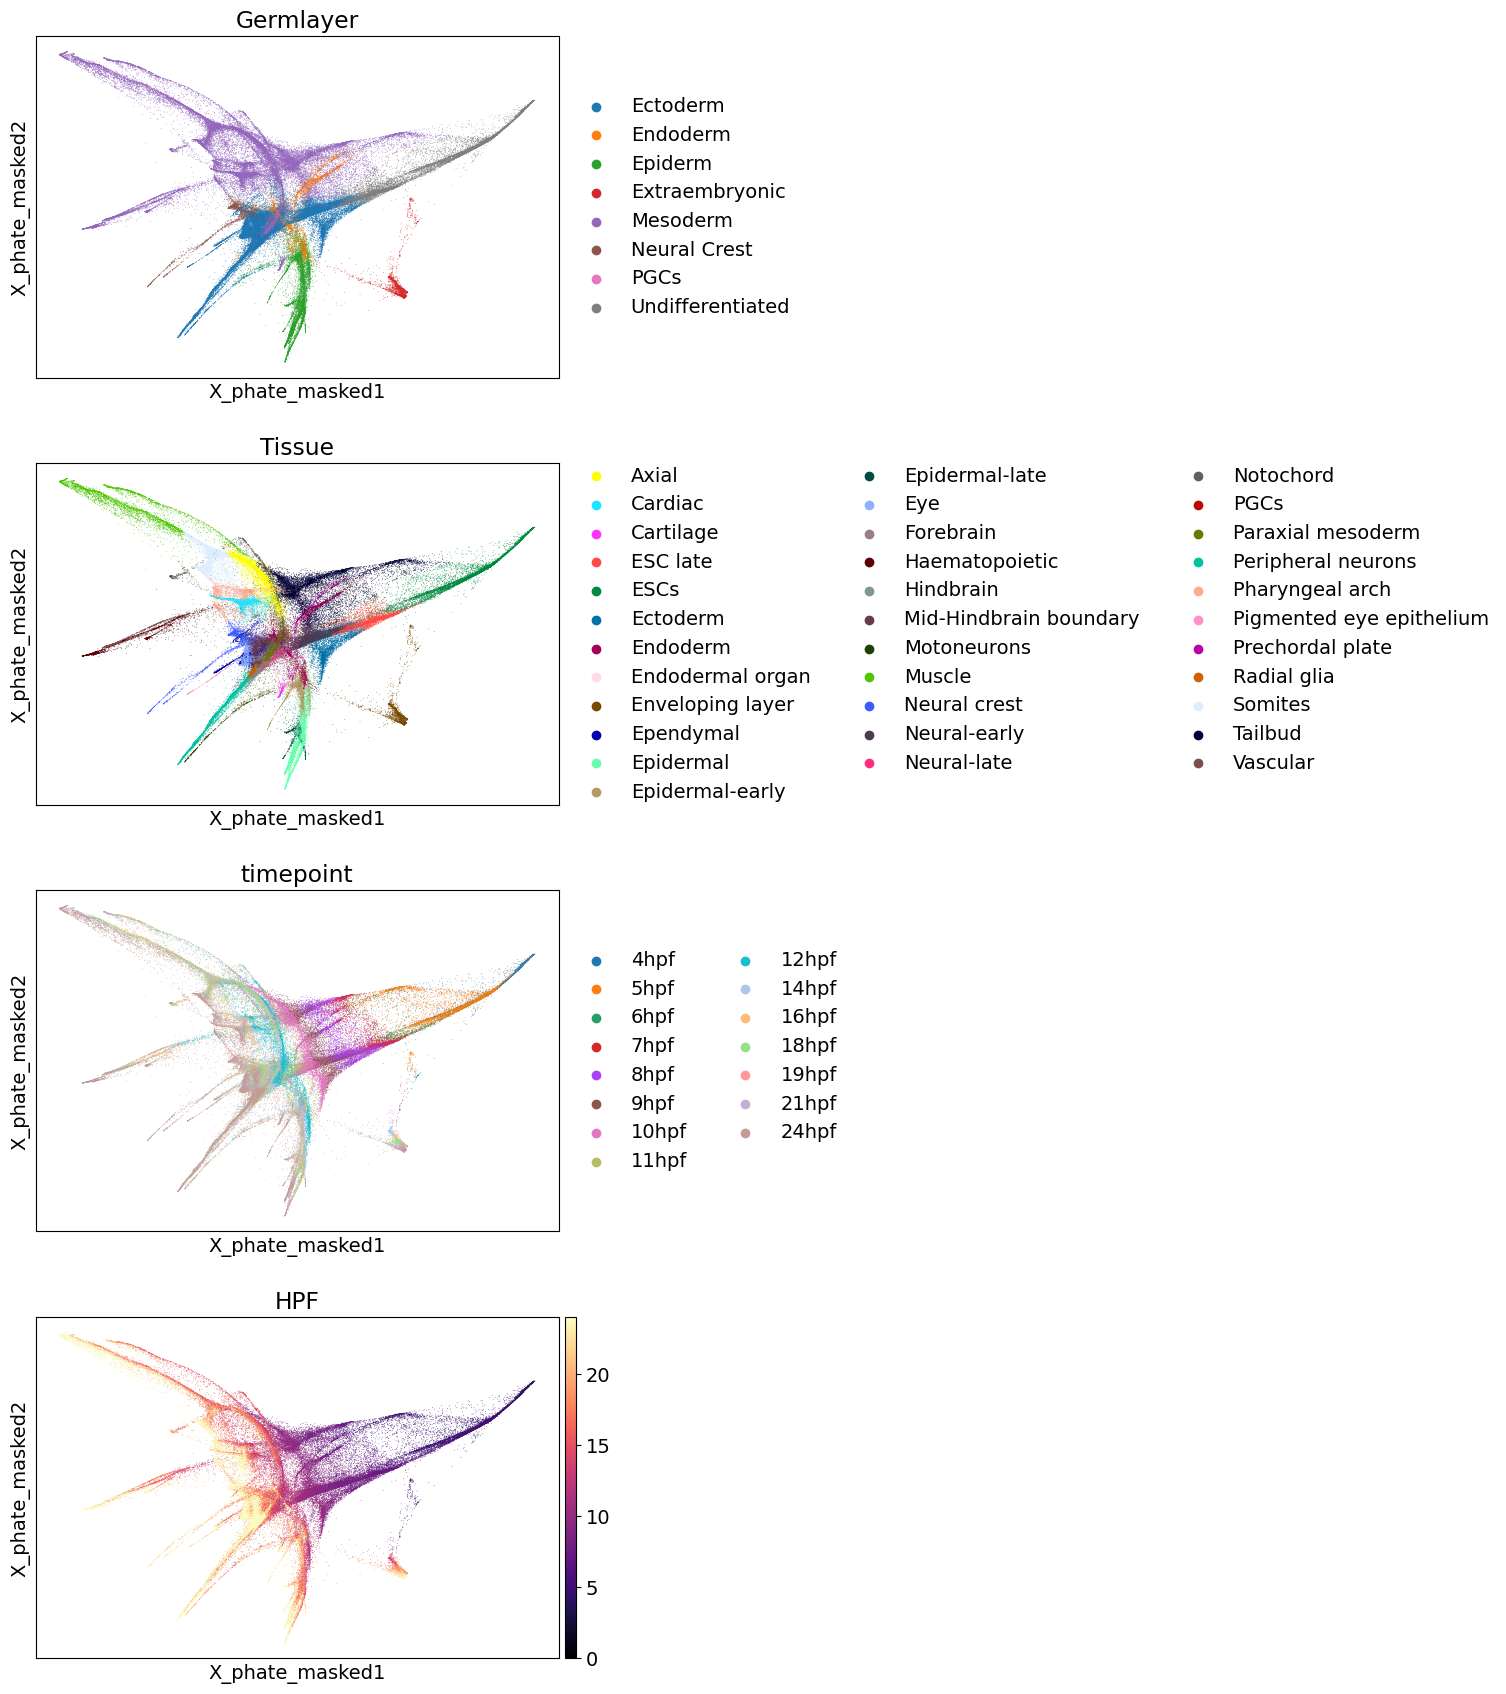

In [12]:
# Retrieve PHATE embedding from the AnnData object
# The embedding is stored in the obsm attribute under 'X_phate_masked'
sdata_zsf_embedding = sdata_zsf.obsm['X_phate_masked']

# Generate a PHATE plot using Scanpy's embedding plotting function
# Customize the plot with multiple color groupings and additional settings
sc.pl.embedding(
    sdata_zsf,  # AnnData object containing the data
    basis='X_phate_masked',  # Specify the PHATE embedding to use
    color=['Germlayer', 'Tissue', 'timepoint', 'HPF'],  # Grouping variables for coloring the plot
    sort_order=True,  # Sort points to ensure plotting order matches data
    vmin=0,  # Minimum value for color mapping
    use_raw=False,  # Use processed data rather than raw data
    color_map='magma',  # Specify the color map to use
    ncols=1  # Arrange plots in a single column
)


In [13]:
# Import the Image class from IPython.display for displaying images in notebooks
from IPython.display import Image

# Define the URL for the image to be displayed
image_url = 'https://nemo.giraldezlab.org/~scott/zsf_reference_4-24hpf_PHATE_HVG_genes_masked_Timepoint.gif'

# Display the image using the Image class
Image(url=image_url)


### Concatenate and calculate QC stats

In [14]:
# Add var and obs info we want to keep to both objects
# Update variable names based on 'EnsemblID'
sdata_MZnps.var_names = sdata_MZnps.var['EnsemblID'].astype('str')

# Assign metadata to observation-level data
sdata_MZnps.obs['timepoint'] = '12hpf'  # Fixed timepoint label
sdata_MZnps.obs['HPF'] = 12  # Numeric timepoint value
sdata_MZnps.obs['sample'] = 'scMZNOS_' + sdata_MZnps.obs['Sample'].astype(str)  # Prefixed sample names

# Assign default values to multiple columns using a dictionary
default_values = {
    'Germlayer': 'scMZNOS',
    'Tissue': 'scMZNOS',
    'study': 'scMZNOS',
    'Shier_germlayer': 'scMZNOS',
    'Shier_tissue': 'scMZNOS',
    'Shier_subtissue': 'scMZNOS'
}
for key, value in default_values.items():
    sdata_MZnps.obs[key] = value


In [15]:
# Validate necessary columns exist in sdata_MZnps.obs
required_columns = ['Raw_GFPCAAX', 'Raw_DSRED38WT', 'Raw_HCD4ENRICHED', 'Expression_GFPCAAX', 'Expression_DSRED38WT', 'Expression_HCD4ENRICHED']
for col in required_columns:
    assert col in sdata_MZnps.obs.columns, f"Column '{col}' is missing in sdata_MZnps.obs"

# Add prediction and sample information
sdata_zsf.obs['tp_prediction'] = sdata_zsf.obs['timepoint']
sdata_zsf.obs['sample'] = sdata_zsf.obs['study'].astype(str) + "_" + sdata_zsf.obs['timepoint'].astype(str)
sdata_zsf.obs['Sample'] = sdata_zsf.obs['sample']

# Initialize placeholder columns with default values
default_obs_values = {
    'Condition': np.nan,
    'KO_clusters': np.nan,
    'Tissue_KO_clusters': np.nan,
    'Host': np.nan,
    'WT': np.nan,
    'KO': np.nan,
    'KO_A': np.nan,
    'KO_B': np.nan,
    'Mutant_A': np.nan,
    'Mutant_B': np.nan,
    'WT_A': np.nan,
    'Detected_GFPCAAX': np.nan,
    'Detected_DSRED38WT': np.nan,
    'Detected_HCD4ENRICHED': np.nan,
    'Detected_any': np.nan,
    'Tissue_prediction': 'zsf',
    'Tissue_prediction_probability': np.nan,
    'Germlayer_prediction': 'zsf',
    'Germlayer_prediction_probability': np.nan
}
sdata_zsf.obs = sdata_zsf.obs.assign(**default_obs_values)

# Add raw and expression data using minimum values from sdata_MZnps
sdata_zsf.obs['Raw_GFPCAAX'] = sdata_MZnps.obs['Raw_GFPCAAX'].min()
sdata_zsf.obs['Raw_DSRED38WT'] = sdata_MZnps.obs['Raw_DSRED38WT'].min()
sdata_zsf.obs['Raw_HCD4ENRICHED'] = sdata_MZnps.obs['Raw_HCD4ENRICHED'].min()
sdata_zsf.obs['Expression_GFPCAAX'] = sdata_MZnps.obs['Expression_GFPCAAX'].min()
sdata_zsf.obs['Expression_DSRED38WT'] = sdata_MZnps.obs['Expression_DSRED38WT'].min()
sdata_zsf.obs['Expression_HCD4ENRICHED'] = sdata_MZnps.obs['Expression_HCD4ENRICHED'].min()


In [16]:
# Merge two AnnData objects, retaining only genes with shared Ensembl IDs
sdata = ad.concat([sdata_MZnps, sdata_zsf], index_unique="_", merge="same", join='inner')

# Dynamically determine dataset origin based on the observation index
source_map = {'0': 'sdata_MZnps', '1': 'zsf'}
sdata.obs['merge'] = sdata.obs.index.astype(str).str[-1].map(source_map)

# Clean up memory by deleting unused variables
del sdata_zsf

# Display the merged dataset and sample counts
sdata
sdata.obs['sample'].value_counts()


/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/anndata/_core/merge.py:1015: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  concat_indices = concat_indices.str.cat(label_col.map(str), sep=index_unique)
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/anndata/_core/merge.py:1026: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/anndata/_core/merge.py:1026: FutureWarning: The beh

sample
Zebrahub_24hpf      12914
Farrell_21hpf        9127
Farrell_18hpf        8315
Farrell_14hpf        7873
scMZNOS_WT_A         7837
Shier_10hpf          7114
Farrell_24hpf        7016
Zebrahub_12hpf       6699
Farrell_16hpf        6688
Zebrahub_16hpf       6297
Shier_8hpf           6178
Zebrahub_19hpf       5899
Shier_5hpf           5716
Shier_9hpf           5442
Shier_12hpf          4404
Shier_7hpf           4101
Zebrahub_14hpf       3862
Shier_4hpf           2625
Shier_11hpf          1614
scMZNOS_Mutant_A     1488
Zebrahub_10hpf       1251
scMZNOS_Mutant_B     1226
Shier_6hpf           1026
Name: count, dtype: int64

In [17]:
# Create timepoint and tissue-specific columns
for tp in sdata.obs["sample"].unique():  # Iterate over unique sample values
    # Directly assign the timepoint label for matching rows
    sdata.obs[tp] = np.where(sdata.obs["sample"] == tp, tp, np.nan)
    
    # Assign tissue-specific values for the matching timepoint
    sdata.obs[f'Tissue_{tp}'] = sdata.obs['Tissue'].where(sdata.obs["sample"] == tp, np.nan)

# Display the updated column names
sdata.obs.columns


Index(['Sample', 'Mutant_A', 'Mutant_B', 'WT_A', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_noncoding', 'log1p_total_counts_noncoding',
       'pct_counts_noncoding', 'Raw_GFPCAAX', 'Raw_DSRED38WT',
       'Raw_HCD4ENRICHED', 'Detected_GFPCAAX', 'Detected_DSRED38WT',
       'Detected_HCD4ENRICHED', 'Detected_any', 'log10_total_counts',
       'Condition', 'Expression_GFPCAAX', 'Expression_DSRED38WT',
       'Expression_HCD4ENRICHED', 'S_score', 'G2M_score', 'phase', 'Host',
       'WT', 'KO', 'KO_A', 'KO_B', 'KO_clusters', 'Tissue_prediction',
       'Tissue_KO_clusters', 'timepoint', 'HPF', 'sample', 'Germlayer',
       'Tissue', 'stud

In [18]:
# Restore var info from multiome
sdata.var = var_info.loc[sdata.var.index]
sdata.var_names = sdata.var.gene_symbol
sdata

AnnData object with n_obs × n_vars = 124712 × 18153
    obs: 'Sample', 'Mutant_A', 'Mutant_B', 'WT_A', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_noncoding', 'log1p_total_counts_noncoding', 'pct_counts_noncoding', 'Raw_GFPCAAX', 'Raw_DSRED38WT', 'Raw_HCD4ENRICHED', 'Detected_GFPCAAX', 'Detected_DSRED38WT', 'Detected_HCD4ENRICHED', 'Detected_any', 'log10_total_counts', 'Condition', 'Expression_GFPCAAX', 'Expression_DSRED38WT', 'Expression_HCD4ENRICHED', 'S_score', 'G2M_score', 'phase', 'Host', 'WT', 'KO', 'KO_A', 'KO_B', 'KO_clusters', 'Tissue_prediction', 'Tissue_KO_clusters', 'timepoint', 'HPF', 'sample', 'Germlayer', 'Tissue', 'study', 'Shier_tissue', 'Shier_subtissue', 'merg

In [19]:
# Make annotations integrating reference tissue, condition and KO cluster information

# Initialize the combined column with 'Condition' values converted to string
sdata.obs['Tissue_Condition_KO_clusters'] = sdata.obs['Condition'].astype('str')

# Replace 'nan' values with corresponding 'Tissue' values using .loc
sdata.obs.loc[
    sdata.obs['Tissue_Condition_KO_clusters'] == 'nan', 'Tissue_Condition_KO_clusters'
] = sdata.obs['Tissue'].astype('str')

# Replace 'KO' values with corresponding 'KO_clusters' values
sdata.obs.loc[
    sdata.obs['Tissue_Condition_KO_clusters'] == 'KO', 'Tissue_Condition_KO_clusters'
] = sdata.obs['KO_clusters']

# Get a sorted, unique list of tissues where the Condition is NaN
tissues = sdata.obs.loc[sdata.obs['Condition'].isna(), 'Tissue'].sort_values().unique().tolist()

# Dynamically generate KO categories and construct the full category order
ko_categories = [f'KO {i}' for i in range(1, 6)]
category_order = ko_categories + ['WT', 'Host'] + tissues

# Convert the combined column to categorical and reorder categories
sdata.obs['Tissue_Condition_KO_clusters'] = sdata.obs['Tissue_Condition_KO_clusters'].astype('category')
sdata.obs['Tissue_Condition_KO_clusters'] = sdata.obs['Tissue_Condition_KO_clusters'].cat.reorder_categories(
    category_order, ordered=True
)


In [20]:
# Make annotations integrating reference HPF, condition and KO cluster information

sdata.obs['HPF_Condition_KO_clusters'] = sdata.obs['Condition'].astype('str')

# Initialize the combined column with 'Condition' values converted to string
sdata.obs['HPF_Condition_KO_clusters'] = sdata.obs['Condition'].astype('str')

# Replace 'nan' values with corresponding 'HPF' values using .loc
sdata.obs.loc[
    sdata.obs['HPF_Condition_KO_clusters'] == 'nan', 'HPF_Condition_KO_clusters'
] = sdata.obs['HPF'].astype('str')

# Replace 'KO' values with corresponding 'KO_clusters' values
sdata.obs.loc[
    sdata.obs['HPF_Condition_KO_clusters'] == 'KO', 'HPF_Condition_KO_clusters'
] = sdata.obs['KO_clusters']

# Dynamically generate KO categories and construct the full category order
ko_categories = [f'KO {i}' for i in range(1, 6)]
HPFs = (
    sdata.obs.loc[sdata.obs['Condition'].isna(), 'HPF']
    .sort_values()
    .unique()
    .astype(str)
    .tolist()
)
category_order = ko_categories + ['WT', 'Host'] + HPFs

# Convert the combined column to categorical and reorder categories
sdata.obs['HPF_Condition_KO_clusters'] = sdata.obs['HPF_Condition_KO_clusters'].astype('category')
sdata.obs['HPF_Condition_KO_clusters'] = sdata.obs['HPF_Condition_KO_clusters'].cat.reorder_categories(
    category_order, ordered=True
)


### Normalise transform score cell cycle

Using normalised and scaled values from each experiment

### Dimensionality reduction, graph and embed


In [21]:
# Define standard VOIs and extend with unique sample identifiers
VOIs = [
    'total_counts', 'pct_counts_in_top_50_genes', 'n_genes_by_counts',
    'phase', 'study', 'sample', 'Germlayer', 'Tissue', 'KO_clusters',
    *sdata.obs['sample'].sort_values().unique()
]

# Ensure the list has no duplicates
VOIs = list(dict.fromkeys(VOIs))

# Display the updated VOIs list
VOIs


['total_counts',
 'pct_counts_in_top_50_genes',
 'n_genes_by_counts',
 'phase',
 'study',
 'sample',
 'Germlayer',
 'Tissue',
 'KO_clusters',
 'Farrell_14hpf',
 'Farrell_16hpf',
 'Farrell_18hpf',
 'Farrell_21hpf',
 'Farrell_24hpf',
 'Shier_10hpf',
 'Shier_11hpf',
 'Shier_12hpf',
 'Shier_4hpf',
 'Shier_5hpf',
 'Shier_6hpf',
 'Shier_7hpf',
 'Shier_8hpf',
 'Shier_9hpf',
 'Zebrahub_10hpf',
 'Zebrahub_12hpf',
 'Zebrahub_14hpf',
 'Zebrahub_16hpf',
 'Zebrahub_19hpf',
 'Zebrahub_24hpf',
 'scMZNOS_Mutant_A',
 'scMZNOS_Mutant_B',
 'scMZNOS_WT_A']

In [22]:
# Remove ribosomal genes

# Define filtering conditions for ribosomal genes
ribosomal_genes = sdata.var.index.str.startswith('rpl') | sdata.var.index.str.startswith('rps')
excluded_genes = sdata.var.index.str.startswith('rps6')  # Genes to retain

# Create the final condition to keep non-ribosomal genes or excluded ones
keep_genes = ~ribosomal_genes | excluded_genes

# Subset the AnnData object based on the condition
sdata = sdata[:, keep_genes]

# Display the updated AnnData object
sdata

View of AnnData object with n_obs × n_vars = 124712 × 18071
    obs: 'Sample', 'Mutant_A', 'Mutant_B', 'WT_A', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_noncoding', 'log1p_total_counts_noncoding', 'pct_counts_noncoding', 'Raw_GFPCAAX', 'Raw_DSRED38WT', 'Raw_HCD4ENRICHED', 'Detected_GFPCAAX', 'Detected_DSRED38WT', 'Detected_HCD4ENRICHED', 'Detected_any', 'log10_total_counts', 'Condition', 'Expression_GFPCAAX', 'Expression_DSRED38WT', 'Expression_HCD4ENRICHED', 'S_score', 'G2M_score', 'phase', 'Host', 'WT', 'KO', 'KO_A', 'KO_B', 'KO_clusters', 'Tissue_prediction', 'Tissue_KO_clusters', 'timepoint', 'HPF', 'sample', 'Germlayer', 'Tissue', 'study', 'Shier_tissue', 'Shier_subtissue

In [23]:
# Number of cells per study
sdata.obs['study'].value_counts()


study
Farrell     39019
Shier       38220
Zebrahub    36922
scMZNOS     10551
Name: count, dtype: int64

In [24]:
# Select highly variable genes from any batch. Keep as study for gods ....

# Initialize list to store all HVGs across batches
HVG_all = []

# Iterate over unique batches in the 'study' column
for batch in sdata.obs['study'].unique():
    # Select HVGs for the current batch
    normalised, HVG_vars = scprep.select.highly_variable_genes(
        sdata[sdata.obs['study'] == batch].X.toarray(),
        sdata[sdata.obs['study'] == batch].var.index,
        cutoff=None,
        percentile=80
    )
    
    # Append batch HVGs to the global list
    HVG_all.extend(HVG_vars)
    
    # Mark HVGs for this batch in the variable metadata
    sdata.var[f'highly_variable_{batch}'] = sdata.var.index.isin(HVG_vars)
    
    # Free memory
    del normalised
    
    # Print progress
    print(f"Unique HVGs after {batch}: {len(np.unique(HVG_all))}")

# Mark genes as HVG across all batches
sdata.var['highly_variable'] = sdata.var.index.isin(HVG_all)


/tmp/ipykernel_1911249/334630348.py:20: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  sdata.var[f'highly_variable_{batch}'] = sdata.var.index.isin(HVG_vars)


Unique HVGs after scMZNOS: 3614
Unique HVGs after Zebrahub: 4893
Unique HVGs after Shier: 6150
Unique HVGs after Farrell: 6638


In [25]:
# Scale within each batch/sample

# Store raw data
sdata.raw = sdata

# Prepare a list to collect scaled batches
scaled_batches = []

# Iterate over unique batches (samples)
for batch in sdata.obs['sample'].unique():
    # Subset data to the current batch and HVGs
    tmp = sdata[sdata.obs['sample'] == batch, sdata.var['highly_variable']]
    
    # Scale the data within the batch
    sc.pp.scale(tmp, copy=False)
    
    # Append the scaled batch to the list
    scaled_batches.append(tmp)

# Concatenate all scaled batches
zscores = ad.concat(scaled_batches)

# Align the scaled data to the original observation order
zscores = zscores[sdata.obs.index, :].X

# Free memory
del tmp
del scaled_batches


/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [26]:
# Calculate the number of significant PCs based on marchenko.pastur max (heuristic)
# Import PCA from sklearn for Principal Component Analysis
from sklearn.decomposition import PCA

# Initialize PCA with 100 components and a fixed random seed for reproducibility
pca = PCA(n_components=100, random_state=42)

# Perform PCA on the dataset (zscores) and obtain the transformed data
X_transformed = pca.fit_transform(zscores)

# Extract the eigenvalues (explained variance) from the PCA
eigenvalues = pca.explained_variance_

# Export gene PCs
pc_loadings = pd.DataFrame(pca.components_, columns=sdata[:, sdata.var['highly_variable']].var.index, index=["PC" + str(i) for i in range(1,100 + 1)])

# Determine the number of features (M) and samples (N) in the dataset
M = np.shape(zscores)[1]  # Number of features
N = np.shape(zscores)[0]  # Number of samples

# Calculate the Marchenko-Pastur maximum eigenvalue threshold
MPmax = (1 + np.sqrt(M/N))**2

# Count the number of eigenvalues greater than the MP threshold
npcs = sum(eigenvalues > MPmax)
print(npcs)  # Print the number of significant principal components

# Clean up memory by deleting the zscores variable
del zscores


100


<Axes: xlabel='Principal Component', ylabel='Explained Variance (%)'>

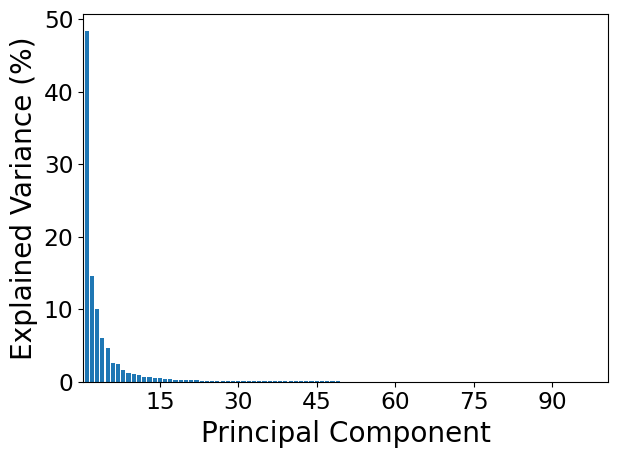

In [27]:
# Scree plot of eigenvalues
scprep.plot.scree_plot(eigenvalues, cumulative=False)


In [28]:
# Add to sdata subsetting to significant PCs
sdata.obsm["X_pca"] = X_transformed[0:,range(npcs)]


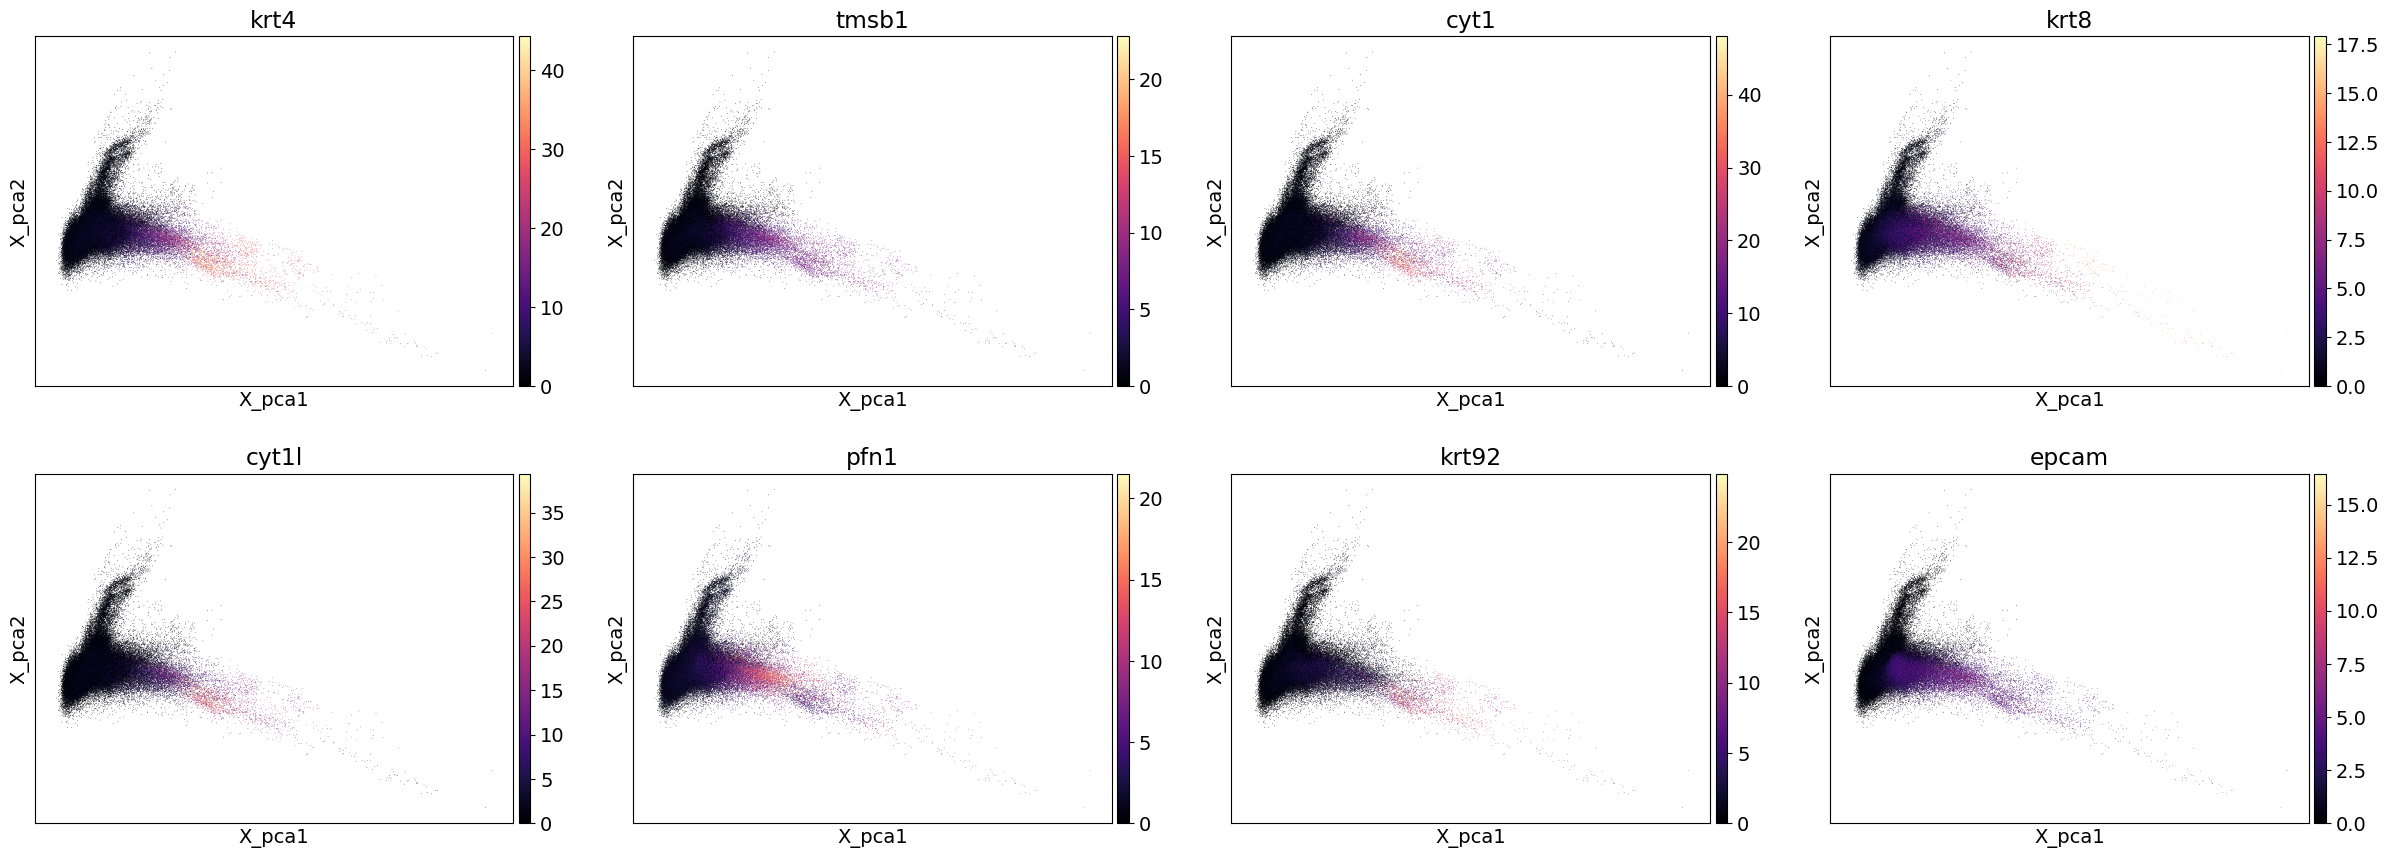

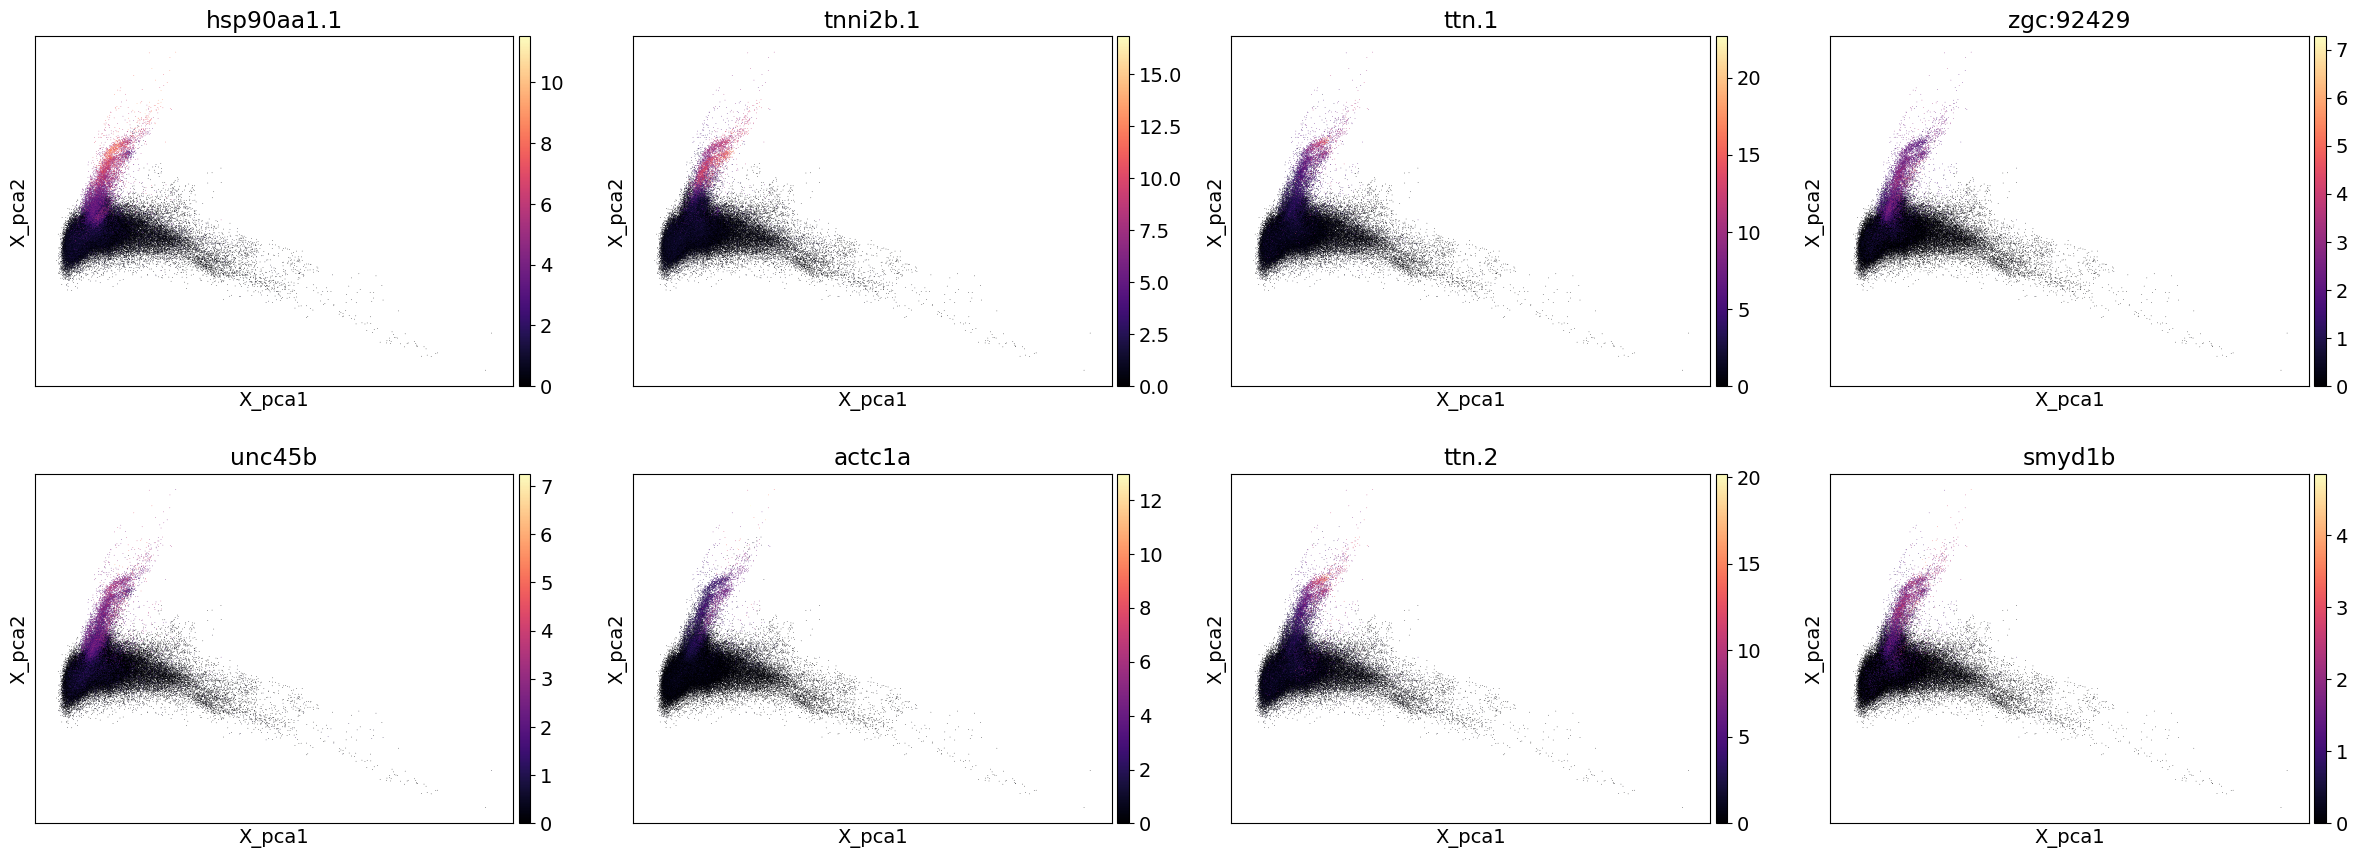

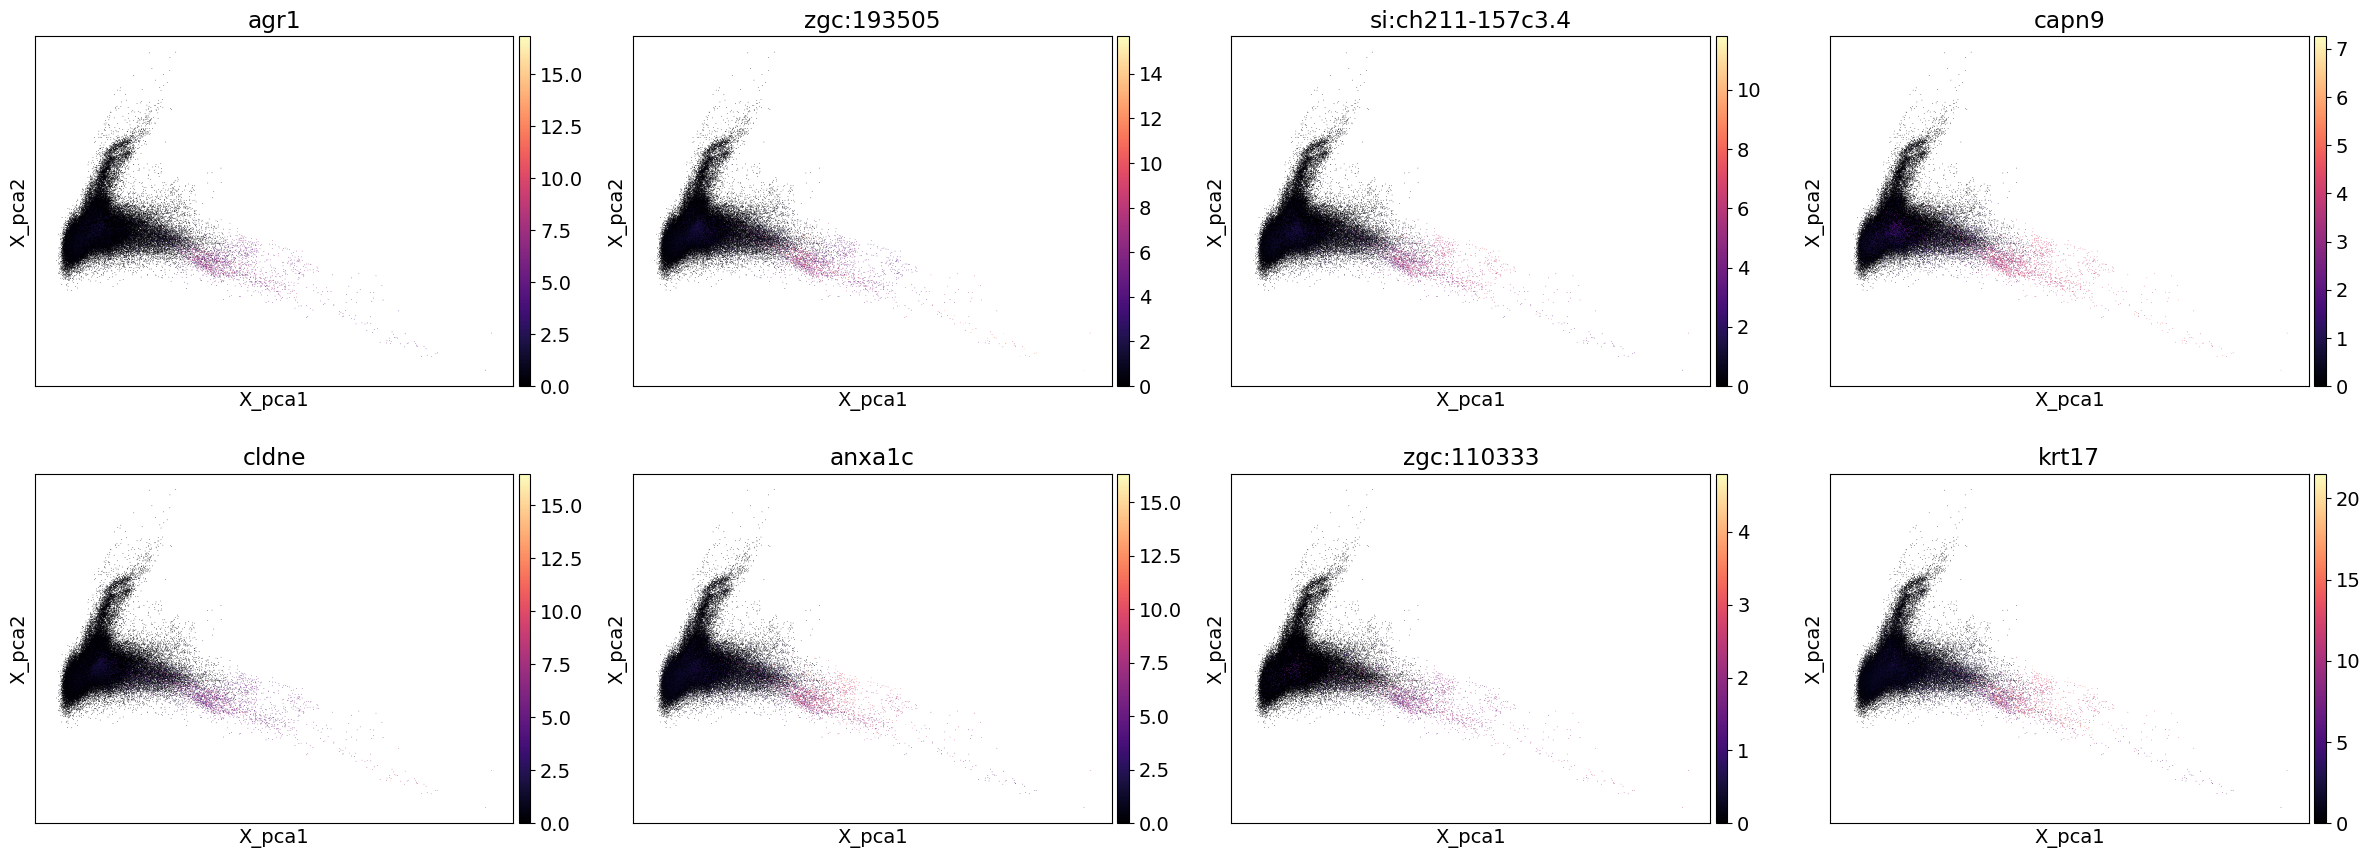

In [29]:
# Loop through the first three principal components (PC1, PC2, PC3)
for i in range(1, 4):
    # Identify the genes with the strongest effect on the current PC
    # Transpose the PC loadings dataframe, take the absolute values of PC[i]'s loadings,
    # sort them in descending order, and select the top 8 genes.
    top_loadings = list(
        pc_loadings.transpose()[f'PC{i}']
        .abs()
        .sort_values(ascending=False)
        .head(8)
        .index
    )

    # Plot the embedding with the strongest effect genes colored by PCA basis
    # Save the plot with a filename indicating the current study and PC
    sc.pl.embedding(
        sdata, 
        basis='X_pca', 
        color=top_loadings, 
        color_map='magma', 
        # save=f'.QC_{study}_PC{i}_top_genes.png'
    )


### Predict tissue and hpf based on knn classifier for each KO cell using PCs

In [30]:
# Import required libraries and methods
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

# Define a filter to select rows where the 'study' column in sdata.obs equals 'scMZNOS'
filt = (sdata.obs.study == 'scMZNOS')

# Define the threshold for k in K-Nearest Neighbors
k_thresh = 5

# Extract PCA-transformed data from the AnnData object
X = sdata.obsm['X_pca']

# Subset the data to exclude rows satisfying the filter
X = X[~filt]


In [31]:
# Predict the label for 'Tissue' based on nearest neighbors

# Specify the label column for prediction
label_col = 'Tissue'

# Extract labels for observations not matching the filter
y = sdata[~filt].obs[label_col]

# Handle missing values: add an 'Unclassified' category and fill NaN values
if y.isnull().values.any():
    y = y.cat.add_categories('Unclassified')  # Add 'Unclassified' as a category
    y = y.fillna('Unclassified')  # Replace NaN values with 'Unclassified'

# Initialize KNN classifier with the specified number of neighbors
knn = KNeighborsClassifier(n_neighbors=k_thresh)

# Train the KNN classifier on the labeled data
knn.fit(X, y)

# Subset PCA-transformed data for unlabelled observations
X_new = sdata.obsm['X_pca']
X_new = X_new[filt]

# Predict labels for the unlabelled observations
y_new = knn.predict(X_new)

# Calculate distances and indices of nearest neighbors
distances, indices = knn.kneighbors(X_new)

# Create a DataFrame for predictions and nearest neighbor statistics
classification = pd.DataFrame(
    y_new, 
    columns=[f'{label_col}_prediction_zsf'], 
    index=sdata.obs.index[filt]
)
classification[f'NN_dist_mean'] = pd.DataFrame(distances, index=sdata.obs.index[filt]).mean(axis=1)


In [32]:
# Predict the label for 'HPF' (Hours Post Fertilization)

# Specify the label column to predict
label_col = 'HPF'

# Extract labeled data for the specified column, excluding filtered observations
y = sdata[~filt].obs[label_col]

# Handle missing values in the labels by adding an 'Unclassified' category and filling NaN values
if y.isnull().values.any():
    y = y.cat.add_categories('Unclassified')
    y = y.fillna('Unclassified')

# Initialize a KNN classifier with the optimized number of neighbors
knn = KNeighborsClassifier(n_neighbors=k_thresh)

# Train the KNN classifier using the PCA-transformed labeled data
knn.fit(X, y)

# Subset to PCA-transformed data for unlabelled observations
X_new = sdata.obsm['X_pca']
X_new = X_new[filt]

# Predict labels for the unlabelled observations
y_new = knn.predict(X_new)

# Compute distances and indices of the nearest neighbors for the unlabelled data
distances, indices = knn.kneighbors(X_new)

# Store the predicted labels in the classification DataFrame under a new column
classification[f'{label_col}_prediction_zsf'] = y_new


In [33]:
# Add predicition to the scMZnps dataset

# Reload a clean preprocessed annotated AnnData object
sdata_MZnps = sc.read_h5ad(f'{scratchdir}/preprocessed_data/Anndata_scmznos_valtor_combined_cells_preprocessed_annotated_FINAL.h5ad')

# Remove suffix '_0' from the indices in the classification DataFrame
classification.index = classification.index.str.removesuffix('_0')

# Merge classification results into the observations of the loaded AnnData object
# Use a left join to ensure all rows in sdata_MZnps.obs are retained
sdata_MZnps.obs = sdata_MZnps.obs.merge(classification, how='left', left_index=True, right_index=True)


### Visualise predicitions

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):

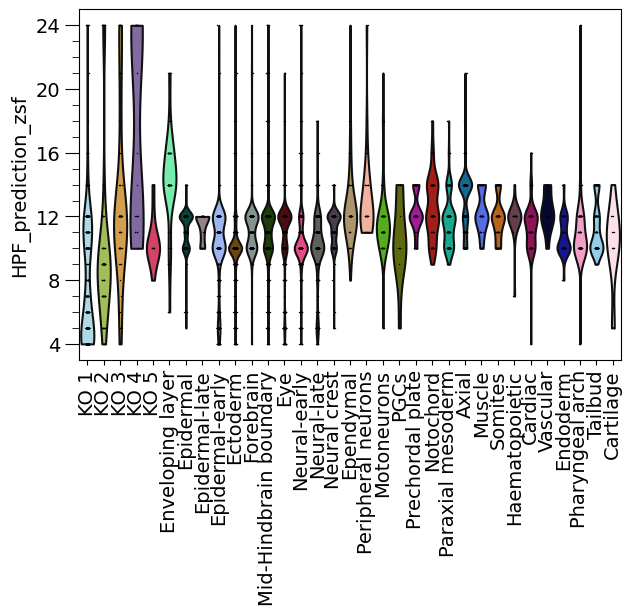

In [34]:
# import matplotlib.pyplot as plt

# # Create the violin plot
# sc.pl.violin(
#     sdata_MZnps,                # Annotated data matrix
#     'HPF_prediction_zsf',       # Feature to plot on the y-axis
#     'Tissue_KO_clusters',       # Grouping column for the x-axis
#     rotation=90,                # Rotate x-axis labels by 90 degrees for better readability
#     vmin=4,                     # Minimum value for the y-axis
#     vmax=24,                    # Maximum value for the y-axis
#     show=False                  # Do not display the plot immediately
# )

# # Get the current Matplotlib figure and axis
# fig = plt.gcf()
# ax = plt.gca()

# # Define custom ticks: major ticks every 4, minor ticks every 2
# major_ticks = range(4, 25, 4)  # Major ticks: 4, 8, 12, 16, 20, 24
# minor_ticks = range(4, 25, 1)  # Minor ticks: 4, 6, 8, ..., 22, 24

# # Apply the custom ticks to the y-axis
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)

# # Customize tick appearance (optional)
# ax.tick_params(axis='y', which='major', length=10)  # Major ticks longer
# ax.tick_params(axis='y', which='minor', length=5)  # Minor ticks shorter

# # Show the plot
# plt.show()


### View nearest neighbours embedding in zsf reference

In [35]:
# Subset the data to include only rows where 'filt' is False
sdata_zsf = sdata[~filt]

# Add a new embedding ('X_phate_masked') to the .obsm attribute of the subsetted data
# 'sdata_zsf_embedding' is assumed to be a precomputed embedding that matches the subset dimensions
sdata_zsf.obsm['X_phate_masked'] = sdata_zsf_embedding


/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

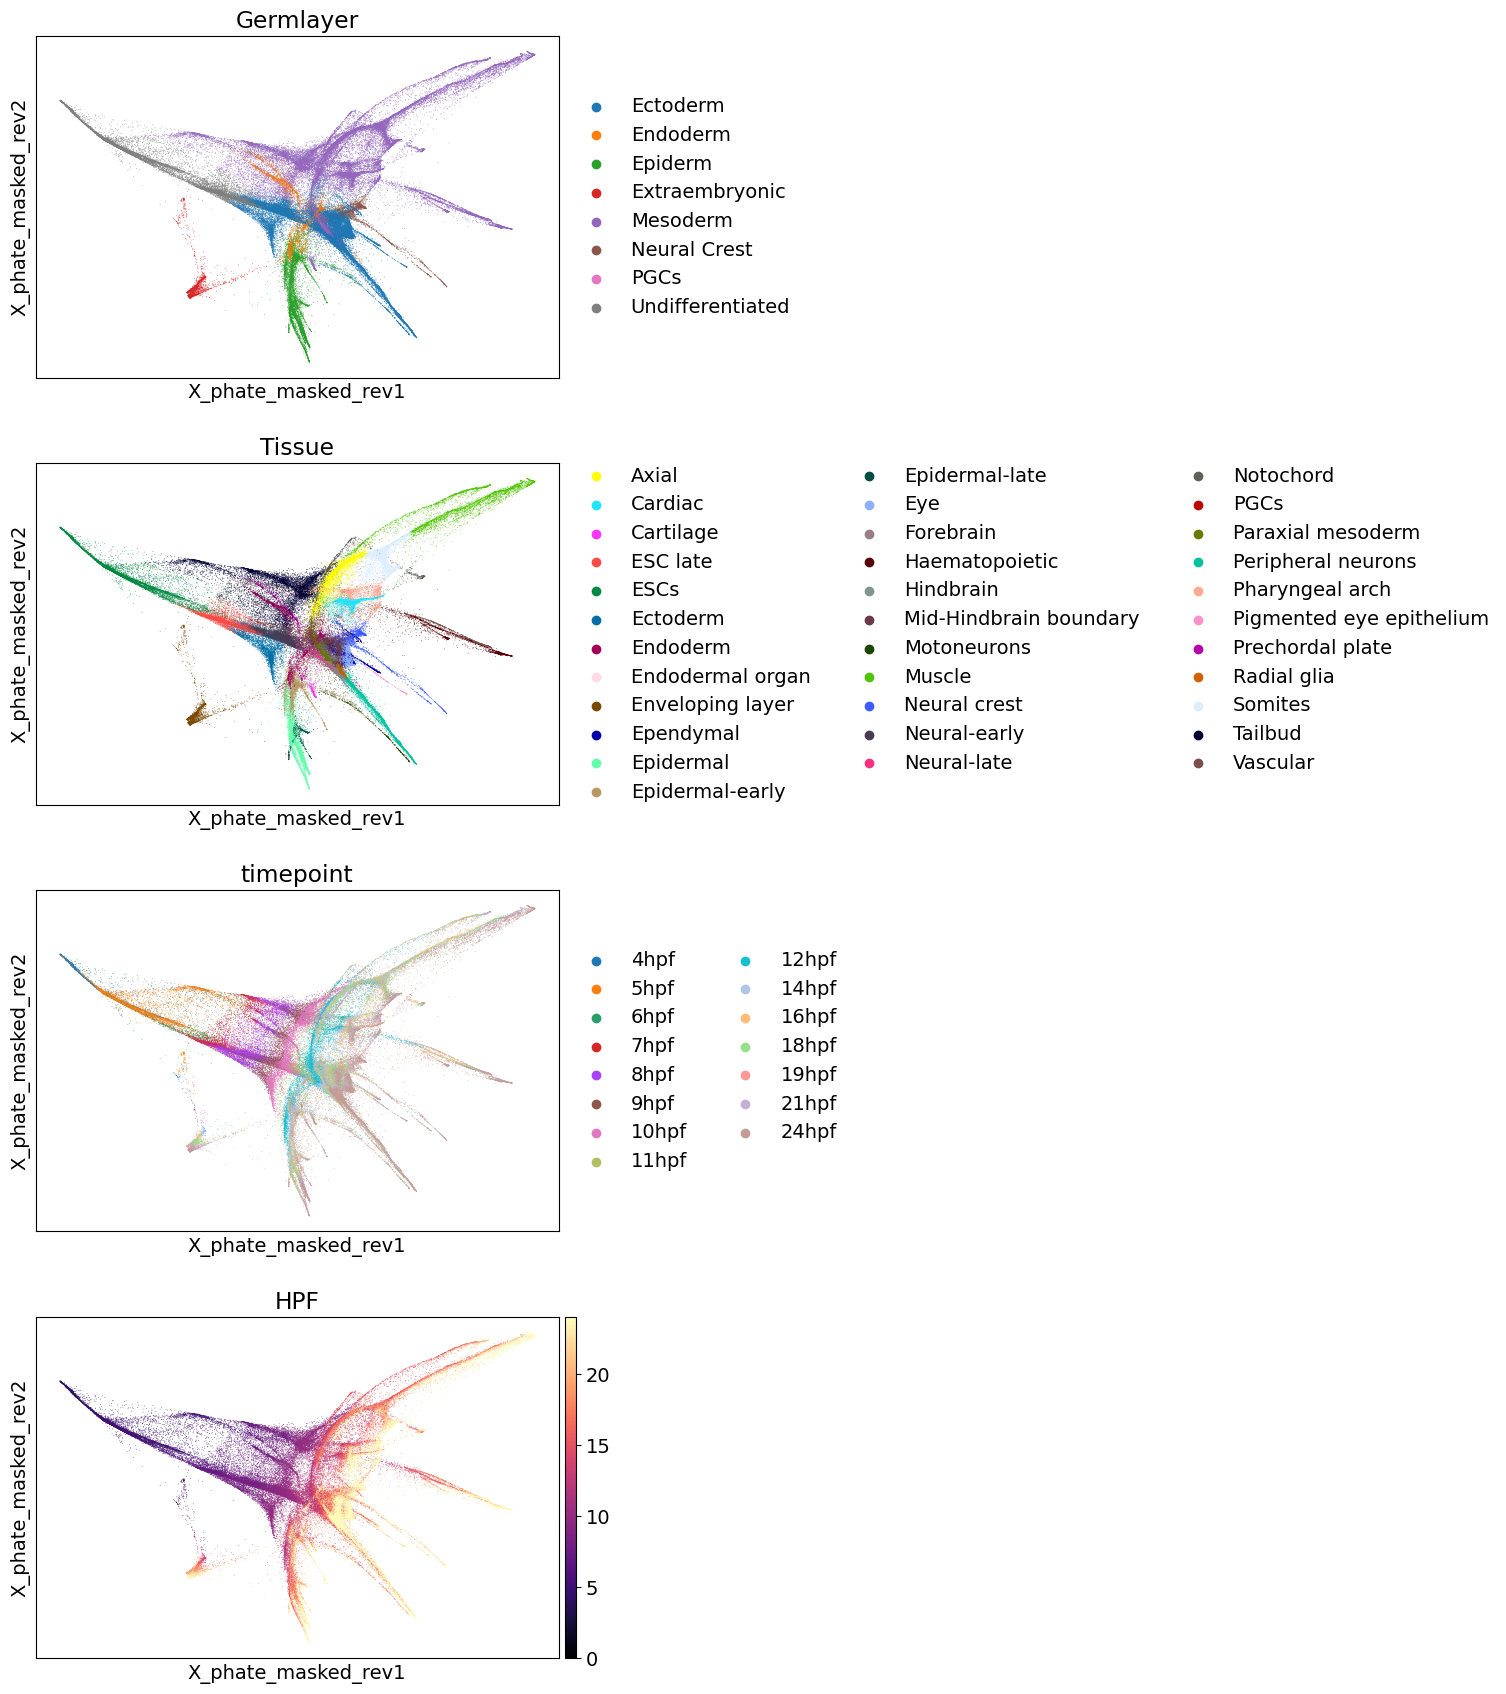

In [36]:
# Invert x axis of embedding so time runs left to right

# Create a copy of the PHATE embedding to modify coordinates
phate_rev = sdata_zsf.obsm['X_phate_masked'].copy()

# Invert the first coordinate (X-axis) to flip the plot horizontally
phate_rev[:, 0] = -phate_rev[:, 0]

# Add the modified coordinates back to the AnnData object under a new key
sdata_zsf.obsm['X_phate_masked_rev'] = phate_rev

# Customize the plot with multiple color groupings and additional settings
sc.pl.embedding(
    sdata_zsf,  # AnnData object containing the data
    basis='X_phate_masked_rev',  # Specify the PHATE embedding to use
    color=['Germlayer', 'Tissue', 'timepoint', 'HPF'],  # Grouping variables for coloring the plot
    sort_order=True,  # Sort points to ensure plotting order matches data
    vmin=0,  # Minimum value for color mapping
    use_raw=False,  # Use processed data rather than raw data
    color_map='magma',  # Specify the color map to use
    ncols=1  # Arrange plots in a single column
)

In [37]:
# Initialize a new column in the obs DataFrame for Tissue KO clusters
sdata_zsf.obs['Tissue_KO_clusters'] = 'None'

# Iterate through each KO cluster category in reverse order
for i in sdata_MZnps.obs.Tissue_KO_clusters.cat.categories[::-1]:
    # Get the indices of nearest neighbors for the current KO cluster
    KO_idx = list(pd.DataFrame(indices[sdata_MZnps.obs.Tissue_KO_clusters == i]).values.flatten())
    
    # Map these indices to the z-scored subset's observation indices
    KO_idx = sdata_zsf.obs.iloc[KO_idx, :].index.to_list()
    
    # Assign the current KO cluster label to the corresponding observations
    sdata_zsf.obs['Tissue_KO_clusters'][sdata_zsf.obs.index.isin(KO_idx)] = i

# Replace remaining 'None' entries with NaN to indicate unassigned observations
sdata_zsf.obs['Tissue_KO_clusters'][sdata_zsf.obs['Tissue_KO_clusters'] == 'None'] = np.nan

# Convert the 'Tissue_KO_clusters' column to a categorical type
sdata_zsf.obs['Tissue_KO_clusters'] = sdata_zsf.obs['Tissue_KO_clusters'].astype('category')

# Reorder categories to match the order in the original KO clusters
sdata_zsf.obs['Tissue_KO_clusters'] = sdata_zsf.obs['Tissue_KO_clusters'].cat.reorder_categories(
    sdata_MZnps.obs['Tissue_KO_clusters'].cat.categories.to_list(), 
    ordered=True
)

# Copy KO cluster color annotations to the z-scored subset
sdata_zsf.uns['Tissue_KO_clusters_colors'] = sdata_MZnps.uns['Tissue_KO_clusters_colors']


/tmp/ipykernel_1911249/3773733918.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sdata_zsf.obs['Tissue_KO_clusters'][sdata_zsf.obs.index.isin(KO_idx)] = i
/tmp/ipykernel_1911249/3773733918.py:13: SettingWithCopyWarning: 
A value is try

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):

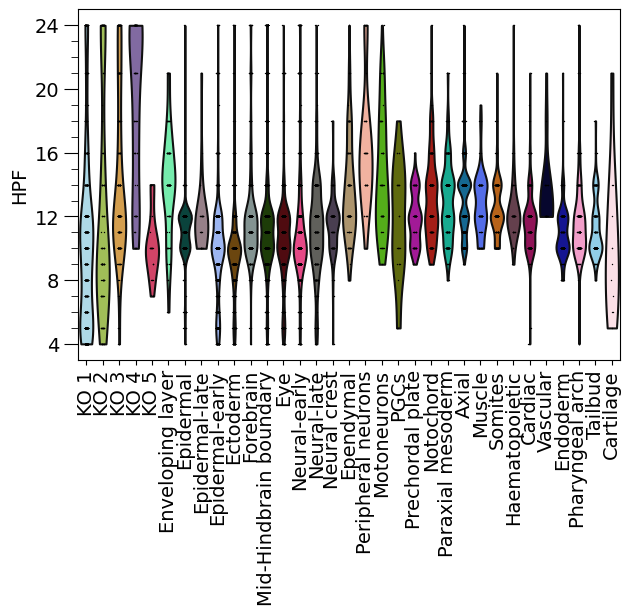

In [38]:
import matplotlib.pyplot as plt

# Create the violin plot
sc.pl.violin(
    sdata_zsf,                # Annotated data matrix
    'HPF',       # Feature to plot on the y-axis
    'Tissue_KO_clusters',       # Grouping column for the x-axis
    rotation=90,                # Rotate x-axis labels by 90 degrees for better readability
    vmin=4,                     # Minimum value for the y-axis
    vmax=24,                    # Maximum value for the y-axis
    show=False                  # Do not display the plot immediately
)

# Get the current Matplotlib figure and axis
fig = plt.gcf()
ax = plt.gca()

# Define custom ticks: major ticks every 4, minor ticks every 2
major_ticks = range(4, 25, 4)  # Major ticks: 4, 8, 12, 16, 20, 24
minor_ticks = range(4, 25, 1)  # Minor ticks: 4, 6, 8, ..., 22, 24

# Apply the custom ticks to the y-axis
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# Customize tick appearance (optional)
ax.tick_params(axis='y', which='major', length=10)  # Major ticks longer
ax.tick_params(axis='y', which='minor', length=5)  # Minor ticks shorter

# Show the plot
plt.show()


In [44]:
# Initialize a new column in the obs DataFrame for Tissue KO clusters
sdata_zsf.obs['Condition'] = 'None'

# Iterate through each KO cluster category in reverse order
for i in ['Host', 'WT', 'KO']:
    # Get the indices of nearest neighbors for the current KO cluster
    KO_idx = list(pd.DataFrame(indices[sdata_MZnps.obs.Condition == i]).values.flatten())
    
    # Map these indices to the reference cell indices
    KO_idx = sdata_zsf.obs.iloc[KO_idx, :].index.to_list()
    
    # Assign the current KO cluster label to the corresponding observations
    sdata_zsf.obs['Condition'][sdata_zsf.obs.index.isin(KO_idx)] = i

# Replace remaining 'None' entries with NaN to indicate unassigned observations
sdata_zsf.obs['Condition'][sdata_zsf.obs['Condition'] == 'None'] = np.nan

# Convert the 'Condition' column to a categorical type
sdata_zsf.obs['Condition'] = sdata_zsf.obs['Condition'].astype('category')

# Reorder categories to match the order in the original KO clusters
sdata_zsf.obs['Condition'] = sdata_zsf.obs['Condition'].cat.reorder_categories(['Host', 'WT', 'KO'], ordered=True)

# Copy KO cluster color annotations to the z-scored subset
sdata_zsf.uns['Condition_colors'] = sdata_MZnps.uns['Condition_colors']


/tmp/ipykernel_725968/2347531019.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sdata_zsf.obs['Condition'][sdata_zsf.obs.index.isin(KO_idx)] = i
/tmp/ipykernel_725968/2347531019.py:13: SettingWithCopyWarning: 
A value is trying to be s

In [45]:
# Index nearest neighbours to KO cells
sdata_zsf.obs['Condition'] = 'None'

for i in ['Host', 'WT', 'KO']:
    KO_idx = list(pd.DataFrame(indices[sdata_MZnps.obs.Condition == i]).values.flatten())
    KO_idx = sdata_zsf.obs.iloc[KO_idx,:].index.to_list()
    sdata_zsf.obs['Condition'][sdata_zsf.obs.index.isin(KO_idx)] = i

sdata_zsf.obs['Condition'][sdata_zsf.obs['Condition'] == 'None'] = np.nan
sdata_zsf.obs['Condition'] = sdata_zsf.obs['Condition'].astype('category')
sdata_zsf.obs['Condition'] = sdata_zsf.obs['Condition'].cat.reorder_categories(['Host', 'WT', 'KO'], ordered=True)


/tmp/ipykernel_725968/2065509476.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sdata_zsf.obs['Condition'][sdata_zsf.obs.index.isin(KO_idx)] = i
/tmp/ipykernel_725968/2065509476.py:7: SettingWithCopyWarning: 
A value is trying to be set

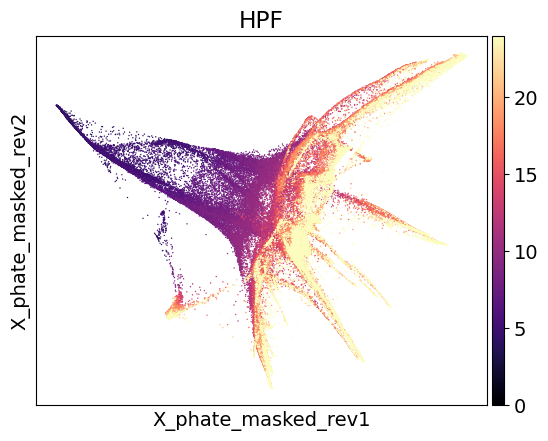

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


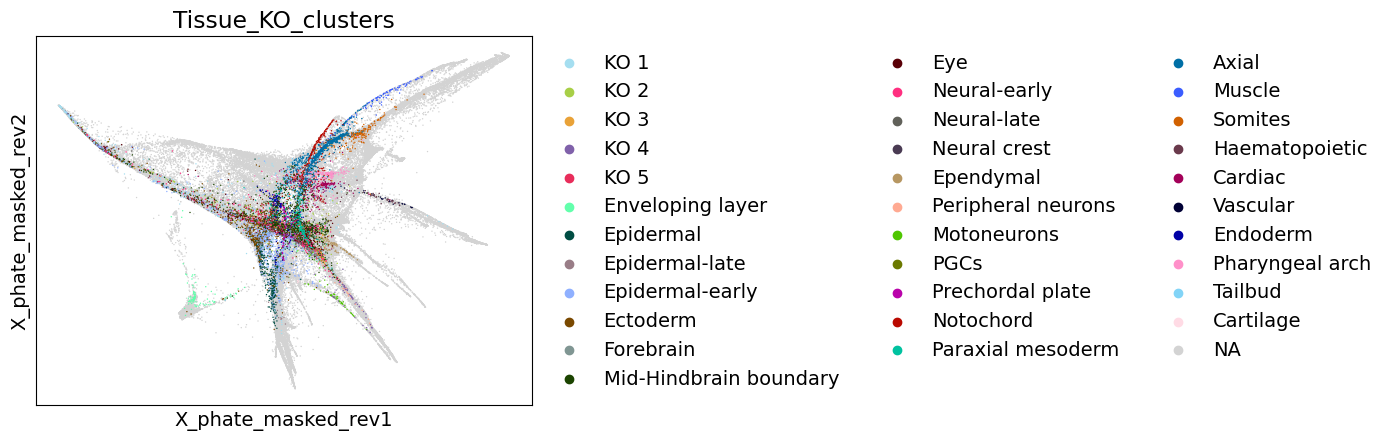

In [46]:
# PLot embedding with HPF and Tissue_KO_clusters
for i in ['HPF', 'Tissue_KO_clusters']:
    sc.pl.embedding(
        sdata_zsf, 
        basis='X_phate_masked_rev', 
        color=i,                # Feature to visualize
        sort_order=True,              # Plot larger points first for better clarity
        vmin=0,                       # Minimum value for color scale
        use_raw=False,                # Use the processed data, not raw counts
        color_map='magma',            # Colormap for visualization
        add_outline=False,            # No outlines for points
        size=4,                       # Point size
        ncols=1,                      # Number of columns in the plot
        # save=f'scMZnps_zsf_24hpf_{i}.pdf'  # Save the plot to a PDF file
    )


/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


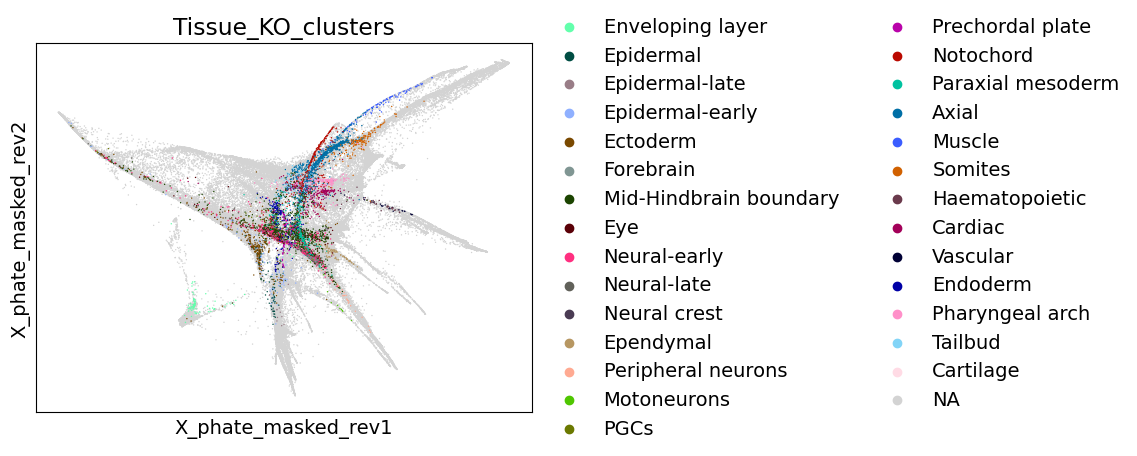

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


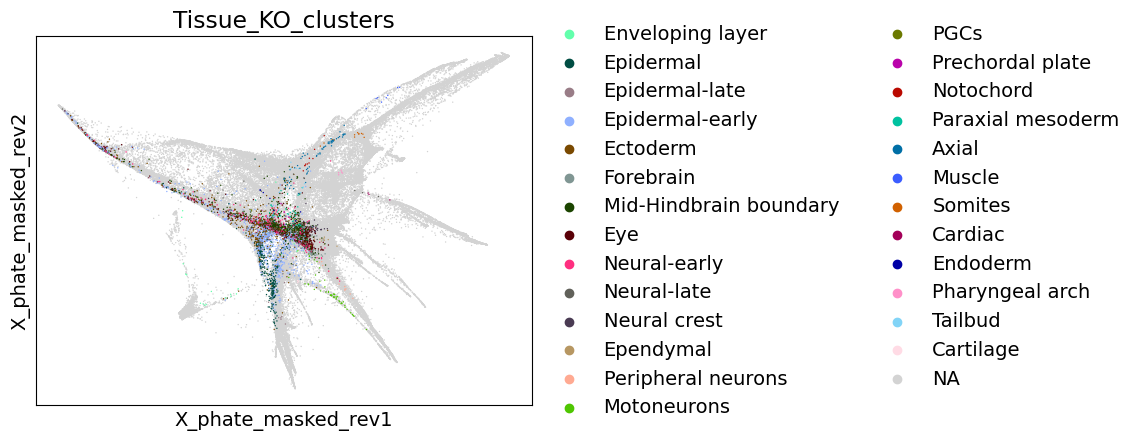

/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


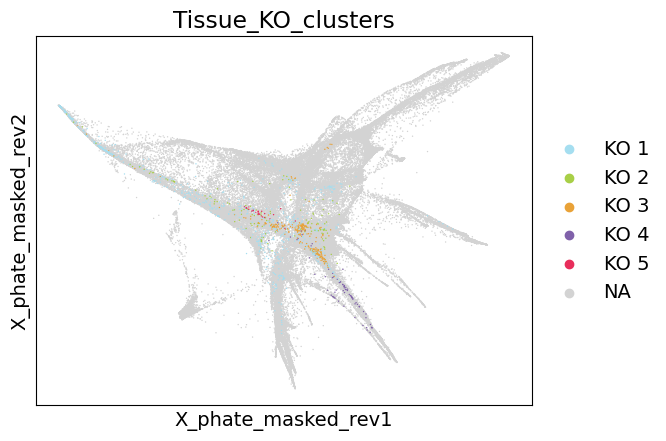

In [47]:
# Plot for each condition
for i in sdata_zsf.obs['Condition'].cat.categories:
    sc.pl.embedding(
        sdata_zsf[(sdata_zsf.obs['Condition'] == i) | sdata_zsf.obs['Condition'].isna()], 
        basis='X_phate_masked_rev', 
        color=['Tissue_KO_clusters'], 
        sort_order=True, 
        vmin=0, 
        use_raw=False, 
        color_map='magma', 
        add_outline=False, 
        size=4, 
        ncols=1, 
        # save=f'scMZnps_zsf_24hpf_Tissue_KO_clusters_NN_combined_embedding_{i}.pdf'
    )

In [52]:
# Annotate KO clusters
sdata_zsf.obs['KO_clusters'] = sdata_zsf.obs.Tissue_KO_clusters.astype(str)
sdata_zsf.obs['KO_clusters'][~sdata_zsf.obs.KO_clusters.str.startswith('KO')] = 'Blank'
sdata_zsf.obs['KO_clusters'] = sdata_zsf.obs['KO_clusters'].astype('category')
sdata_zsf.obs['KO_clusters'] = sdata_zsf.obs['KO_clusters'].cat.reorder_categories(['KO 1', 'KO 2', 'KO 3', 'KO 4', 'KO 5', 'Blank'])
sdata_zsf.uns['KO_clusters_colors'] = sdata_zsf.uns['Tissue_KO_clusters_colors'][0:5] + ['grey80']

/tmp/ipykernel_725968/674807675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdata_zsf.obs['KO_clusters'][~sdata_zsf.obs.KO_clusters.str.startswith('KO')] = 'Blank'


In [62]:
# List of cluster columns to process
cluster_columns = ['KO_clusters']  # Extendable to multiple columns

# Iterate over each specified cluster column
for clust in cluster_columns:
    # Use pandas.get_dummies to generate binary indicators for each category
    sample_indicators = pd.get_dummies(
        sdata_zsf.obs[clust], 
        prefix=f'{clust} cluster', 
        dtype='int'
    )
    # Remove underscores from column names in the `obs` DataFrame
    sample_indicators.columns = sample_indicators.columns.str.replace('_', ' ', regex=False)
   
    # Merge the binary indicators back into the original 'obs' DataFrame
    sdata_zsf.obs = pd.concat([sdata_zsf.obs, sample_indicators], axis=1)

# At this point, `sdata_zsf.obs` includes binary columns for each cluster


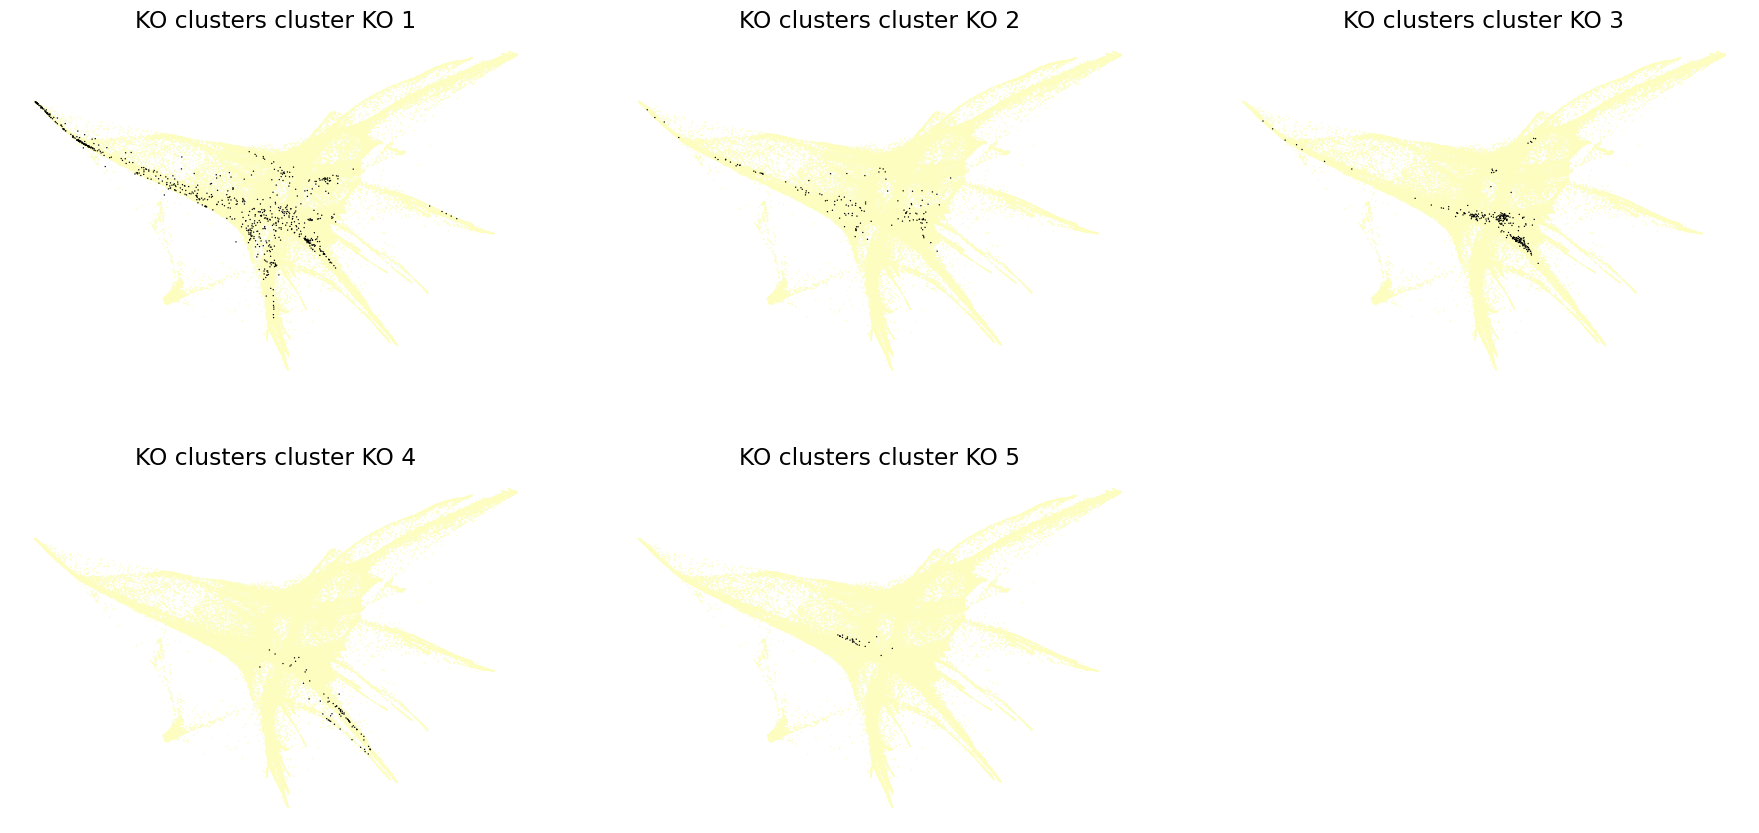

In [65]:
# View all clusters individually for a given resolution.
res = 'KO_clusters'
clusts = sdata_zsf.obs.columns[sdata_zsf.obs.columns.str.startswith('KO clusters cluster').tolist()]
clusts = [i for i in clusts if i != 'KO clusters cluster Blank'] 

sc.pl.embedding(
    sdata_zsf, 
    basis='X_phate_masked_rev',  # Specify the embedding (assumed to be precomputed)
    color=[*clusts],  # Provide the list of cluster columns to visualize
    add_outline=False, 
    colorbar_loc=None, 
    legend_fontsize=12, 
    legend_fontoutline=2, 
    frameon=False, 
    size=4, 
    ncols=3,  # Arrange plots into 3 columns
    cmap='magma_r',  # Specify the colormap
    # save=f'scMZnps_zsf_24hpf_KO_clusters_NN_map.pdf'  # Save to the specified file
)

### Calculate the significance of enrichment of nearest neighbors for each KO subpopulations

In [68]:
# Combine 'Tissue' and 'HPF' into a single label and calculate total cell counts
sdata_zsf.obs['Tissue_HPF'] = sdata_zsf.obs['Tissue'].astype(str) + '_' + sdata_zsf.obs['HPF'].astype(str)
tissue_counts = (
    sdata_zsf.obs.groupby('Tissue_HPF').size().reset_index(name='Total')
)
tissue_counts.set_index('Tissue_HPF', inplace=True)

# Calculate the abundance of nearest neighbors for selected clusters
selected_clusters = ['KO 1', 'KO 2', 'KO 3', 'KO 4', 'KO 5']
KO_NN = (
    sdata_zsf.obs[sdata_zsf.obs['Tissue_KO_clusters'].isin(selected_clusters)]
    .groupby(['Tissue_KO_clusters', 'Tissue_HPF']).size().unstack(fill_value=0)
)

# Merge the total cell counts with the nearest neighbor counts
total_NN = tissue_counts.join(KO_NN, how='left').fillna(0)


/tmp/ipykernel_725968/564824997.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Tissue_KO_clusters', 'Tissue_HPF']).size().unstack(fill_value=0)


In [70]:
# Create a dictionary for enrichment analysis based on the resolution
import gseapy as gp

res = 'Tissue'
tissue_dict = {
    tiss: sdata_zsf.obs[sdata_zsf.obs[res] == tiss].index.to_list()
    for tiss in sdata_zsf.obs[res].unique()
}

# Perform enrichment analysis for each cluster
res_dfs = []
for clust in ['KO 1', 'KO 2', 'KO 3', 'KO 4', 'KO 5']:
    # Select cells belonging to the current cluster
    cell_list = sdata_zsf.obs[sdata_zsf.obs['Tissue_KO_clusters'] == clust].index.to_list()
    print(f'Number of cells in {clust}: {len(cell_list)}')
    
    # Run enrichment analysis using gseapy
    enr2 = gp.enrich(
        gene_list=cell_list,
        gene_sets=tissue_dict,
        background=sdata_zsf.obs.index.to_list(),
        cutoff=0.05,
        outdir=None,
        verbose=True
    )
    
    # Process results and calculate log-transformed statistics
    results = enr2.results
    results['logOR'] = np.log2(results['Odds Ratio'])
    results['log10_p'] = -np.log10(results['Adjusted P-value'])
    results['sig'] = results['Adjusted P-value'] < 0.05
    results = results.sort_values('Adjusted P-value', ascending=True)
    results['Cluster'] = clust
    
    # Print and collect results for the current cluster
    print(results.head(50))
    res_dfs.append(results)


2024-12-18 23:21:51,811 [INFO] Input dict object named with gs_ind_0
2024-12-18 23:21:51,812 [INFO] Run: gs_ind_0 
2024-12-18 23:21:51,833 [INFO] Done.
2024-12-18 23:21:51,842 [INFO] Input dict object named with gs_ind_0
2024-12-18 23:21:51,843 [INFO] Run: gs_ind_0 
2024-12-18 23:21:51,858 [INFO] Done.
2024-12-18 23:21:51,866 [INFO] Input dict object named with gs_ind_0
2024-12-18 23:21:51,867 [INFO] Run: gs_ind_0 
2024-12-18 23:21:51,882 [INFO] Done.
2024-12-18 23:21:51,893 [INFO] Input dict object named with gs_ind_0
2024-12-18 23:21:51,894 [INFO] Run: gs_ind_0 
2024-12-18 23:21:51,908 [INFO] Done.
2024-12-18 23:21:51,915 [INFO] Input dict object named with gs_ind_0
2024-12-18 23:21:51,916 [INFO] Run: gs_ind_0 
2024-12-18 23:21:51,929 [INFO] Done.


Number of cells in KO 1: 723
    Gene_set                    Term   Overlap       P-value  \
2   gs_ind_0                    ESCs  226/7987  9.982210e-85   
3   gs_ind_0                Ectoderm   82/3378  6.957868e-25   
16  gs_ind_0                    PGCs    12/166  9.531629e-10   
1   gs_ind_0                ESC late   49/4340  9.125345e-05   
0   gs_ind_0                 Cardiac   34/2765  2.415767e-04   
4   gs_ind_0                Endoderm   27/2468  4.968687e-03   
7   gs_ind_0         Epidermal-early   32/3049  4.346626e-03   
9   gs_ind_0               Forebrain   43/4512  5.857156e-03   
8   gs_ind_0          Epidermal-late     9/814  7.732678e-02   
11  gs_ind_0  Mid-Hindbrain boundary   53/7827  3.265086e-01   
12  gs_ind_0            Neural crest   20/3064  4.768352e-01   
10  gs_ind_0               Hindbrain    2/2237  9.999909e-01   
21  gs_ind_0                 Tailbud   36/7913  9.872818e-01   
13  gs_ind_0            Neural-early   37/7098  9.072704e-01   
14  gs_ind_

/tmp/ipykernel_725968/1638856799.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  marker = res_df.pivot_table(values='logOR', columns='Term', index='Cluster')
/tmp/ipykernel_725968/1638856799.py:22: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pval = res_df.pivot_table(values='log10_p', columns='Term', index='Cluster')
/home/scott/scripts/scmultiome_curbos_scripts/multiome/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


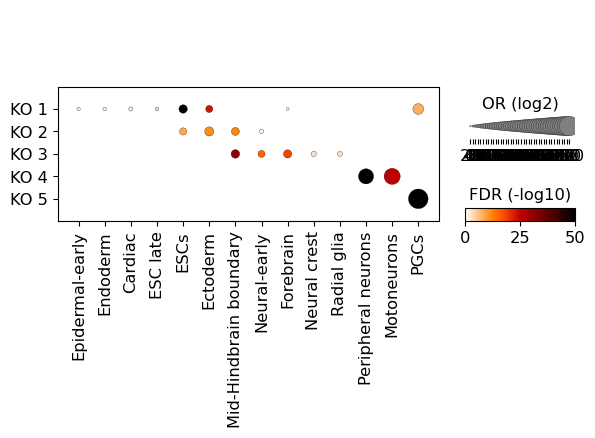

In [71]:
# Combine all enrichment result DataFrames into a single DataFrame
res_df = pd.concat(res_dfs)

# Filter for significant results only
res_df = res_df[res_df['sig']]

# Convert the 'Term' column to a categorical type and reorder categories for plotting
res_df['Term'] = res_df['Term'].astype('category')
res_df['Term'] = res_df['Term'].cat.reorder_categories([
    'Epidermal-early', 'Endoderm', 'Cardiac', 'ESC late', 'ESCs', 'Ectoderm',
    'Mid-Hindbrain boundary', 'Neural-early', 'Forebrain', 'Neural crest',
    'Radial glia', 'Peripheral neurons', 'Motoneurons', 'PGCs'
])

# Pivot the data for bubble plot preparation
marker = res_df.pivot_table(values='logOR', columns='Term', index='Cluster')

# Clip values to a maximum of 8 for better visualization
marker[marker > 8] = 8

# Pivot again for p-values to determine bubble size
pval = res_df.pivot_table(values='log10_p', columns='Term', index='Cluster')

# Create a dummy AnnData object to leverage Scanpy's dotplot functionality
dummy = sc.AnnData(marker)

# Assign variable names and observation names for dotplot compatibility
dummy.var['Cluster'] = dummy.var_names.to_list()
dummy.obs['Term'] = dummy.obs_names.to_list()
dummy.obs['Term'] = dummy.obs['Term'].astype('category')

# Plot the dotplot
sc.pl.dotplot(
    dummy, 
    dummy.var['Cluster'].to_list(), 
    'Term', 
    dendrogram=False, 
    dot_size_df=marker, 
    dot_color_df=pval, 
    size_title='OR (log2)', 
    colorbar_title='FDR (-log10)', 
    cmap='gist_heat_r', 
    vmin=0, 
    vmax=50, 
    # save='scMZnps_KO_clusters_nearest_neighbors_enrichment.pdf'
)


In [72]:
# List of cluster columns to process
cluster_columns = ['Tissue']  # Extendable to multiple columns

# Iterate over each specified cluster column
for clust in cluster_columns:
    # Use pandas.get_dummies to generate binary indicators for each category
    sample_indicators = pd.get_dummies(
        sdata_zsf.obs[clust], 
        prefix=f'{clust} cluster', 
        dtype='int'
    )
    # Remove underscores from column names in the `obs` DataFrame
    sample_indicators.columns = sample_indicators.columns.str.replace('_', ' ', regex=False)
   
    # Merge the binary indicators back into the original 'obs' DataFrame
    sdata_zsf.obs = pd.concat([sdata_zsf.obs, sample_indicators], axis=1)

# At this point, `sdata_zsf.obs` includes binary columns for each cluster


/tmp/ipykernel_725968/3314343030.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(sdata_zsf.obs['Tissue'])


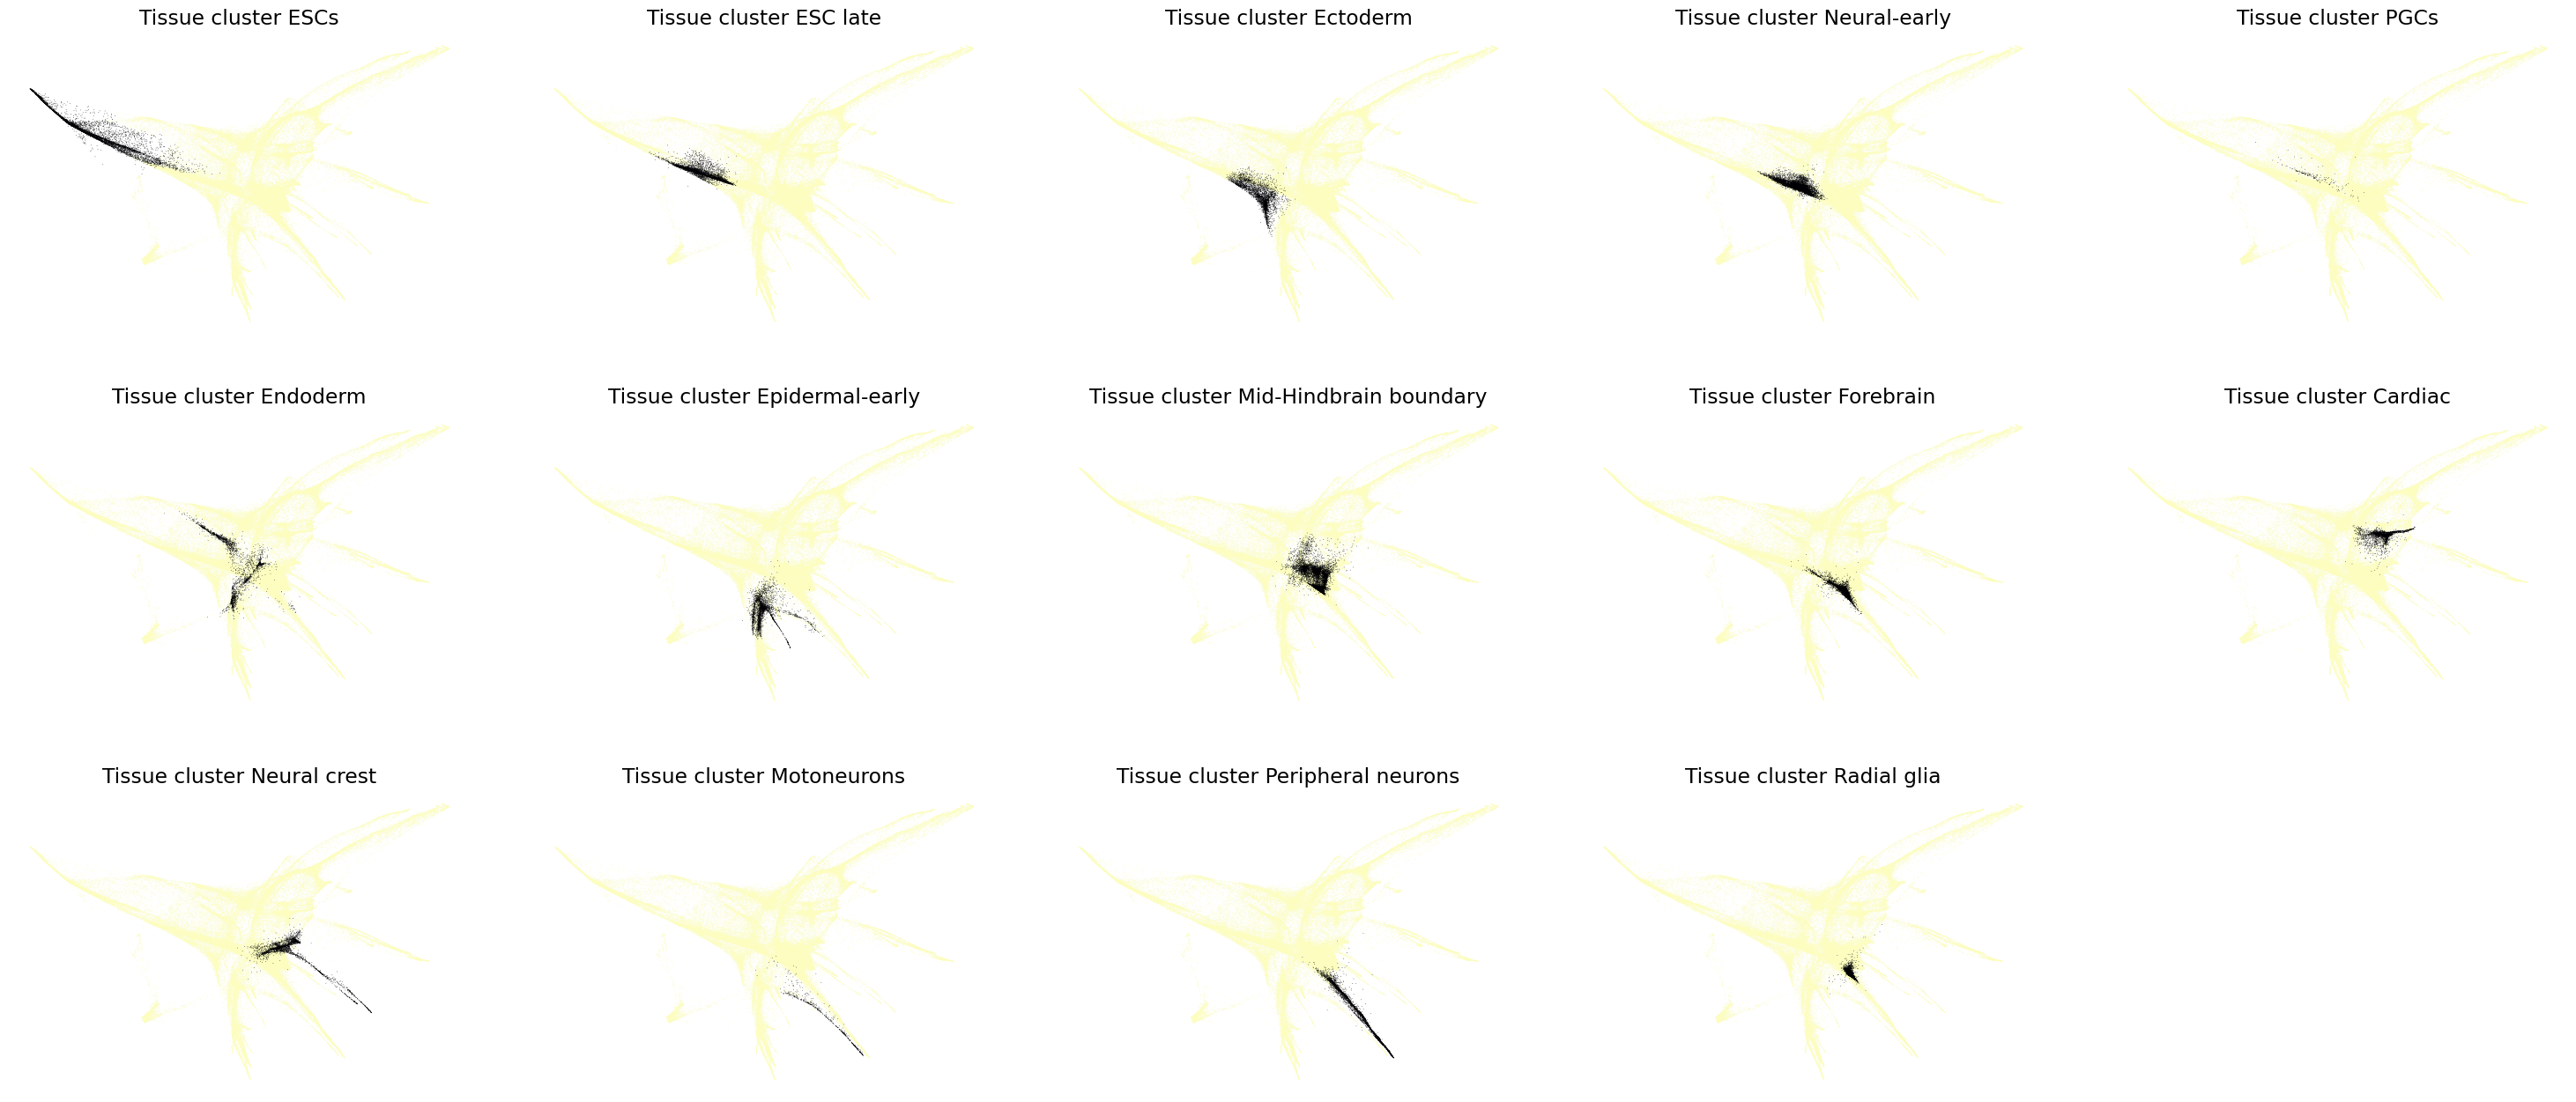

In [74]:
# Calculate the mean age (HPF) for each tissue and order tissues by ascending mean age
tissue_order = (
    sdata_zsf.obs['HPF']
    .groupby(sdata_zsf.obs['Tissue'])
    .mean()
    .sort_values(ascending=True)
    .reset_index()
)

# Filter tissue names to those present in the marker matrix columns and convert to a list
tissue_order = tissue_order.Tissue[tissue_order.Tissue.isin(marker.columns.to_list())].to_list()

# List of cluster names for visualization, based on ordered tissues
res = 'Tissue'
clusts = [f'Tissue cluster {i}' for i in tissue_order]

# Visualize the clusters in the specified embedding using Scanpy's embedding plotting function
sc.pl.embedding(
    sdata_zsf, 
    basis='X_phate_masked_rev',  # Precomputed embedding
    color=clusts, 
    add_outline=False, 
    colorbar_loc=None, 
    legend_fontsize=12, 
    legend_fontoutline=2, 
    frameon=False, 
    ncols=5,  # Arrange subplots in 5 columns
    cmap='magma_r', 
    # save='scMZnps_KO_clusters_nearest_neighbors_enriched_tissues.pdf'
)


### Calculate correlation between scMZnps tissue annotations and reference annotations at 12hpf

/tmp/ipykernel_725968/2281467391.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sdata.obs['Tissue_combined'][sdata.obs['study'] != 'scMZNOS'] = 'zsf_' + sdata.obs['Tissue'].astype(str) + '_' + sdata.obs['HPF'].astype(str)
/tmp/ipykernel

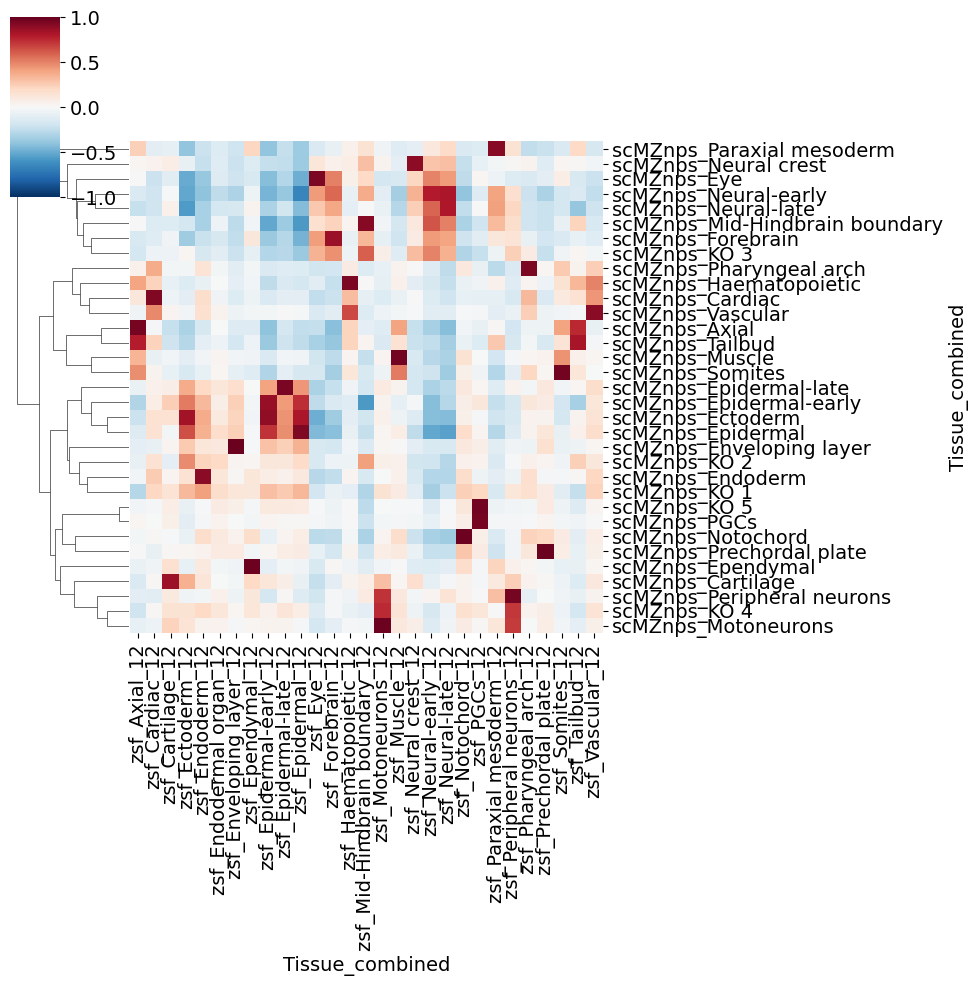

<Figure size 100000x1000 with 0 Axes>

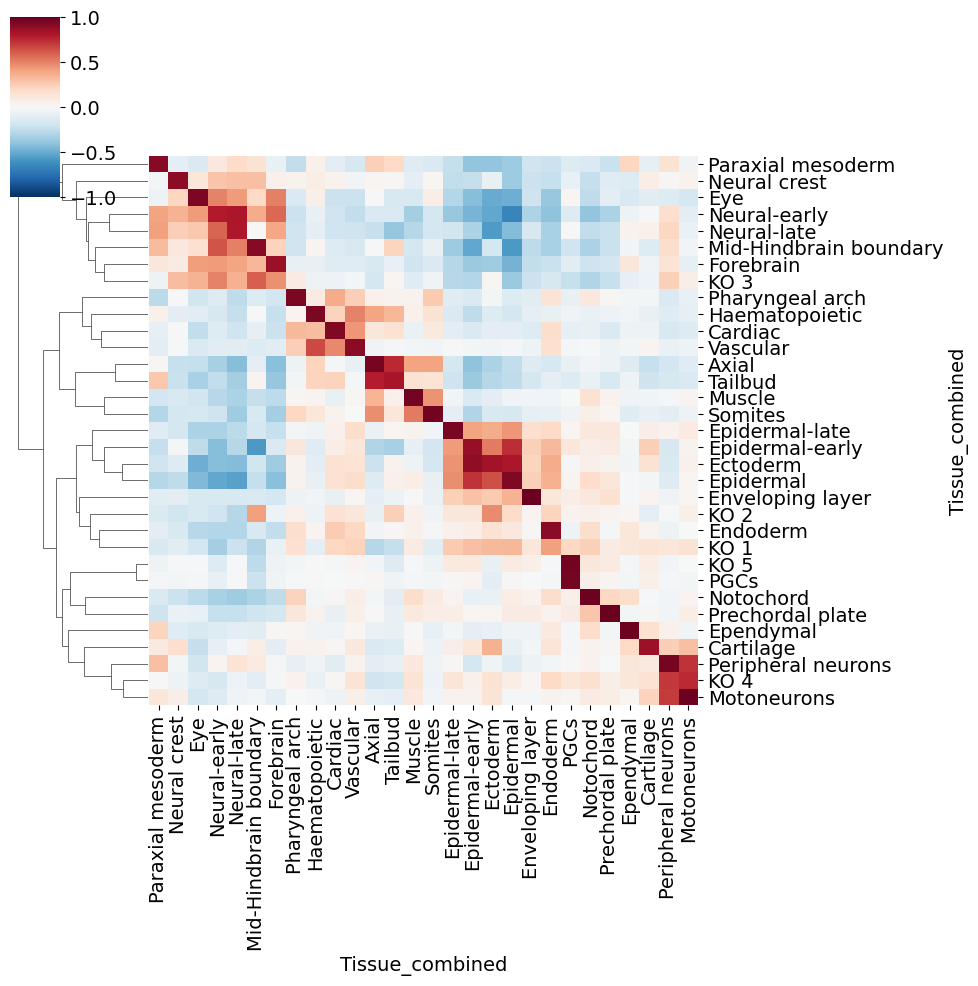

In [42]:
# Create a new column 'Tissue_combined' in the 'obs' DataFrame by concatenating a string with the column values
sdata.obs['Tissue_combined'] = 'scMZnps_' + sdata.obs['Tissue_KO_clusters'].astype(str)

# Update the 'Tissue_combined' column for rows where 'study' is not 'scMZNOS'
# The new value combines 'Tissue' and 'HPF' columns with a 'zsf_' prefix
sdata.obs['Tissue_combined'][sdata.obs['study'] != 'scMZNOS'] = (
    'zsf_' + sdata.obs['Tissue'].astype(str) + '_' + sdata.obs['HPF'].astype(str)
)

# Convert PCA matrix into a DataFrame for easier manipulation, using observation indices and naming PCs
pcs_dense = pd.DataFrame(
    sdata.obsm['X_pca'], 
    index=sdata.obs.index, 
    columns=[f'PC{i}' for i in range(100)]
)

# Add the 'Tissue_combined' column to the PCA DataFrame for grouping
pcs_dense['Tissue_combined'] = sdata.obs['Tissue_combined']

# Group PCA values by 'Tissue_combined', calculate the mean, and transpose for correlation
pseudobulk_pc_df = pcs_dense.groupby('Tissue_combined').mean().transpose()

# Compute the correlation matrix of the transposed pseudobulk PCA DataFrame
corr_mat = pseudobulk_pc_df.corr()

# Subset columns of interest for queries and references
# 'query_cols' selects columns starting with 'scMZnps_'
query_cols = pseudobulk_pc_df.columns[pseudobulk_pc_df.columns.str.startswith('scMZnps_')]

# 'ref_cols' selects columns starting with 'zsf_' and ending with '_12'
ref_cols = pseudobulk_pc_df.columns[
    pseudobulk_pc_df.columns.str.startswith('zsf_') & pseudobulk_pc_df.columns.str.endswith('12')
]

# Subset the correlation matrix to focus on 'query_cols' vs. 'ref_cols'
corr_mat = corr_mat.loc[query_cols.to_list(), ref_cols.to_list()]

# Create a clustered heatmap of the correlation matrix with custom settings
g = sns.clustermap(
    corr_mat, 
    vmin=-1, vmax=1, 
    cmap='RdBu_r', 
    xticklabels=True, 
    yticklabels=True, 
    row_cluster=True, 
    col_cluster=False,
    pl
)

# Refine the correlation matrix to focus on specific rows/columns based on clustering
corr_mat = corr_mat[
    [
        i for i in (
            corr_mat.index[[int(i) for i in g.dendrogram_row.dendrogram['ivl']]]
            .str.replace('scMZnps_', 'zsf_') + '_12'
        ).to_list() 
        if 'KO' not in i
    ]
]

# Clean up column and index names by removing prefixes and suffixes
corr_mat.columns = corr_mat.columns.str.removeprefix('zsf_').str.removesuffix('_12')
corr_mat.index = corr_mat.index.str.removeprefix('scMZnps_')

# Save and display the reordered correlation matrix heatmap
plt.figure(figsize=(1000,10))
g = sns.clustermap(
    corr_mat, 
    vmin=-1, vmax=1, 
    cmap='RdBu_r', 
    xticklabels=True, 
    yticklabels=True, 
    row_cluster=True, 
    col_cluster=False
)
# Uncomment to save the plot: plt.savefig(f'{syncdir}/scMZnps_zsf_reference_tissue_corr_map.pdf')
plt.show()


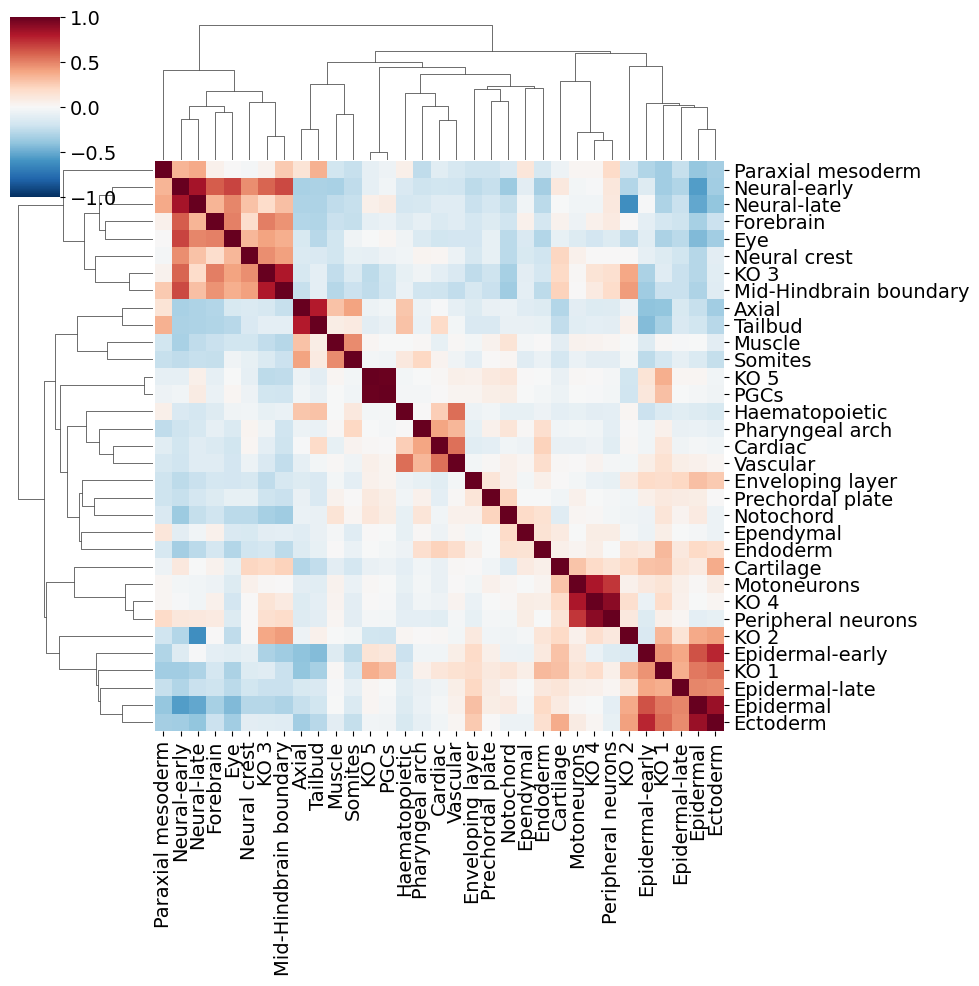

In [37]:
# Corr between query tissues and their nearest neighbors

# Initialize a list to store PCA means for each KO subpopulation
nn_pcs = []

# Loop through each category in the 'Tissue_KO_clusters' column
for i in sdata_MZnps.obs.Tissue_KO_clusters.cat.categories.to_list():
    # Get indices of nearest neighbors for the current KO cluster
    KO_idx = list(pd.DataFrame(indices[sdata_MZnps.obs.Tissue_KO_clusters == i]).values.flatten())
    
    # Extract indices for the subset of the z-scored subset (sdata_zsf)
    KO_idx = sdata_zsf.obs.iloc[KO_idx, :].index.to_list()
    
    # Extract PCA embeddings for these indices
    KO_pca = pd.DataFrame(sdata.obsm['X_pca'], index=sdata.obs.index).loc[KO_idx, :]
    
    # Append the mean PCA values for this KO cluster
    nn_pcs.append(KO_pca.mean(axis=0))

# Concatenate the mean PCA values into a DataFrame
nn_pcs = pd.concat(nn_pcs, axis=1)

# Set column names as the KO cluster categories
nn_pcs.columns = sdata_MZnps.obs.Tissue_KO_clusters.cat.categories.to_list()

sns.clustermap(nn_pcs.corr(),
               xticklabels=True,   # Display x-axis labels (cluster names)
               yticklabels=True,   # Display y-axis labels (cluster names)
               cmap='RdBu_r',      # Use red-to-blue diverging colormap
               vmin=-1,            # Minimum value for colormap (correlation)
               vmax=1)             # Maximum value for colormap (correlation)
